# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [22]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [23]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [24]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [25]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [26]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [27]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [28]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [29]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
pt = PowerTransformer()
df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [30]:
df=np.nan_to_num(df)

In [31]:
df

array([[-1.84688137, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.82422371,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.80166973, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.25582441,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.26682846, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.27779988, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

In [32]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [33]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [34]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 17) (20631, 1)


In [35]:
X_train_new = []
y_train_new = []
i = 0
count = 0
while i < len(X_train):
    temp_x = []
    temp_y = []
    j = int(max_cycles[count])
    count = count+1
    if j == 0:
        break
    while j!=0:
        temp_x.append(X_train[i])
        temp_y.append(int(y_train[i][0]))
        i=i+1
        j=j-1
    X_train_new.append(temp_x)
    y_train_new.append(temp_y)


In [36]:
print(y_train_new[0])

[192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [37]:
def create_dataset(X, look_back=10):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

for i in range(len(X_train_new)):
    X_train_new[i] = create_dataset(X_train_new[i])
    y_train_new[i] = y_train_new[i][11:]
    y_train_new[i] = np.array(y_train_new[i])

In [38]:
def build_model(layers):
        #d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam')
        return model

In [39]:
model = build_model([17,10])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 128)           74752     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 125,217
Trainable params: 125,217
Non-trainable params: 0
_________________________________________________________________
None


--------------------------------------- Current Engine : 1  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 2s 2s/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 5/75
1/1 [==============================] - 0s 52ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 7/75
1/1 [==============================] - 0s 51ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 8/75
1/1 [==============================] - 0s 56ms/step - loss: 12975.6670 - val_loss: 275.5000
Epoch 9/75
1/1 [==============================] - 0s 50ms/step - loss: 12975.6

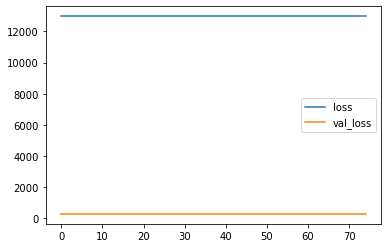

--------------------------------------- Current Engine : 2  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 103ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 30003.1660 - val_loss: 609.1667
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 3000

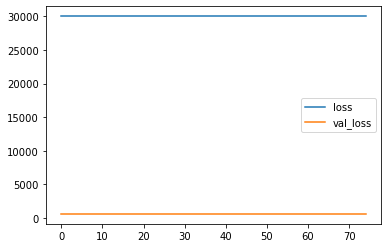

--------------------------------------- Current Engine : 3  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 74ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 2/75
1/1 [==============================] - 0s 31ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 4/75
1/1 [==============================] - 0s 34ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 5/75
1/1 [==============================] - 0s 31ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 7/75
1/1 [==============================] - 0s 32ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 11186.5000 - val_loss: 238.5000
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 11186

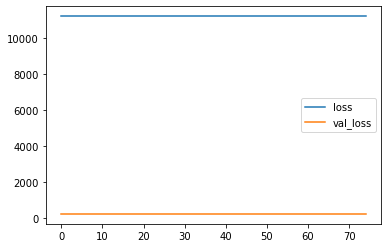

--------------------------------------- Current Engine : 4  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 94ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 2/75
1/1 [==============================] - 0s 31ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 4/75
1/1 [==============================] - 0s 33ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 5/75
1/1 [==============================] - 0s 29ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 7/75
1/1 [==============================] - 0s 38ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 12509.0000 - val_loss: 256.6667
Epoch 9/75
1/1 [==============================] - 0s 30ms/step - loss: 12509

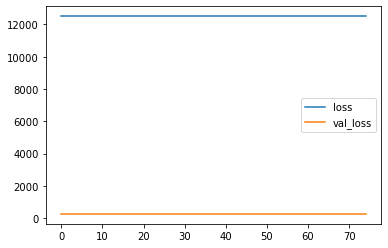

--------------------------------------- Current Engine : 5  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 84ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 3/75
1/1 [==============================] - 0s 31ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 5/75
1/1 [==============================] - 0s 31ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 26197.6660 - val_loss: 526.6667
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 26197

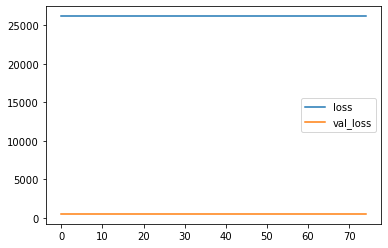

--------------------------------------- Current Engine : 6  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 102ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 12381.1670 - val_loss: 256.6667
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 1238

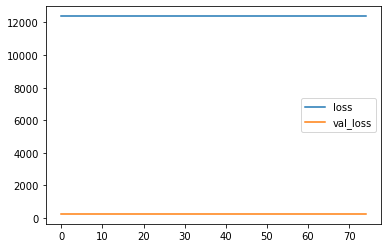

--------------------------------------- Current Engine : 7  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 86ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 24267.1660 - val_loss: 500.5000
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 24267

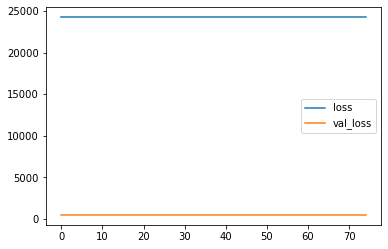

--------------------------------------- Current Engine : 8  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 102ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 8/75
1/1 [==============================] - 0s 40ms/step - loss: 7640.5000 - val_loss: 157.6667
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 7640.5000 - 

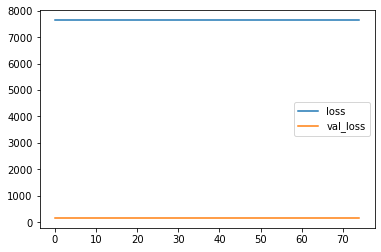

--------------------------------------- Current Engine : 9  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 100ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 8/75
1/1 [==============================] - 0s 40ms/step - loss: 14260.0000 - val_loss: 295.0000
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 1426

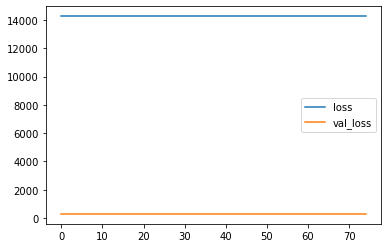

--------------------------------------- Current Engine : 10  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 86ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 17554.0000 - val_loss: 357.5000
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 1755

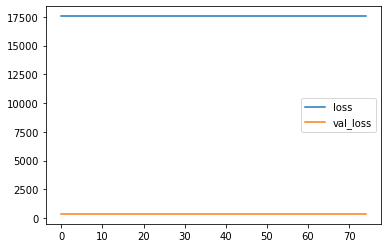

--------------------------------------- Current Engine : 11  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 86ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 20692.5000 - val_loss: 426.0000
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 2069

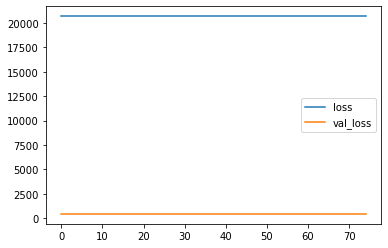

--------------------------------------- Current Engine : 12  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 85ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 9982.6670 - val_loss: 204.1667
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 9982.6670 - 

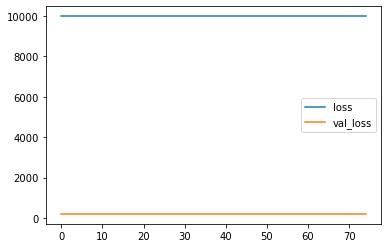

--------------------------------------- Current Engine : 13  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 9130.6670 - val_loss: 188.0000
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 9130.1172 - val_loss: 187.9089
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 9129.0166 - val_loss: 187.7861
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 9127.0830 - val_loss: 187.6405
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 9123.3516 - val_loss: 187.3747
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 9116.5234 - val_loss: 186.2411
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 9105.4561 - val_loss: 183.2724
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 9090.7363 - val_loss: 180.5613
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 9074.8594 -

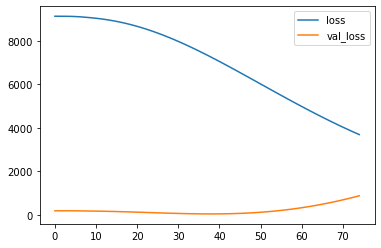

--------------------------------------- Current Engine : 14  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 4968.7314 - val_loss: 853.4177
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 4869.8442 - val_loss: 904.0244
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 4771.3252 - val_loss: 956.7194
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 4673.3970 - val_loss: 1011.4615
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 4576.2642 - val_loss: 1068.2065
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 4480.1035 - val_loss: 1126.9092
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 4385.0723 - val_loss: 1187.5215
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 4291.3105 - val_loss: 1249.9937
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 4198.9

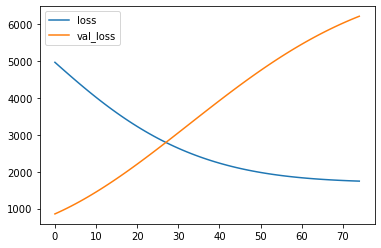

--------------------------------------- Current Engine : 15  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 15208.2617 - val_loss: 5965.3579
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 15218.9131 - val_loss: 5997.1636
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 15219.9980 - val_loss: 6023.8286
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 15220.3135 - val_loss: 6045.8052
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 15219.7422 - val_loss: 6063.3950
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 15218.1328 - val_loss: 6076.3594
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 15215.2646 - val_loss: 6084.8267
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 15210.9023 - val_loss: 6089.0415
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - l

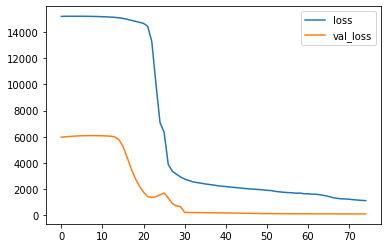

--------------------------------------- Current Engine : 16  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 5215.6948 - val_loss: 105.1513
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 5143.6631 - val_loss: 101.5171
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 5047.9492 - val_loss: 97.1177
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 4945.8164 - val_loss: 92.3839
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 4840.5132 - val_loss: 87.6035
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 4734.8086 - val_loss: 82.9723
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 4621.9927 - val_loss: 78.6271
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 4485.3584 - val_loss: 74.6737
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 4322.9785 - val_lo

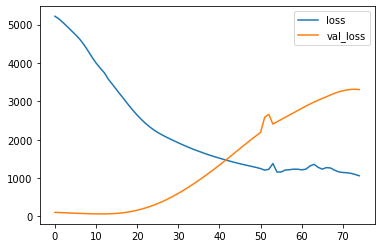

--------------------------------------- Current Engine : 17  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 103ms/step - loss: 3425.9133 - val_loss: 5485.4087
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 3346.5383 - val_loss: 5337.2686
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 3170.8413 - val_loss: 5186.8115
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 3005.0891 - val_loss: 4952.1406
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 2908.1689 - val_loss: 4848.3540
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 2815.9065 - val_loss: 4739.2451
Epoch 7/75
1/1 [==============================] - 0s 41ms/step - loss: 2718.9150 - val_loss: 4631.5918
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 2651.2122 - val_loss: 4525.5459
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 259

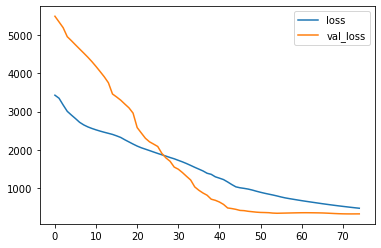

--------------------------------------- Current Engine : 18  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 2719.3762 - val_loss: 1796.0450
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 1945.2906 - val_loss: 1727.8092
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 710.6483 - val_loss: 1653.1014
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 462.6198 - val_loss: 1578.1902
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 573.9089 - val_loss: 1509.5051
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 805.9380 - val_loss: 1449.5829
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 899.9152 - val_loss: 1401.8469
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 791.4658 - val_loss: 1363.3754
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 550.9189 -

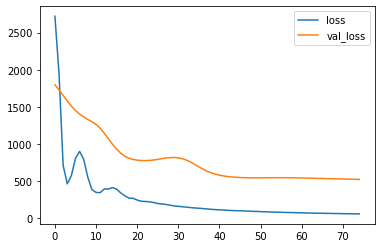

--------------------------------------- Current Engine : 19  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 102ms/step - loss: 2968.3328 - val_loss: 1492.1519
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 2881.2278 - val_loss: 1205.4658
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 2707.0071 - val_loss: 882.8986
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 2228.9619 - val_loss: 668.0831
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 1776.5392 - val_loss: 533.8119
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 1467.6975 - val_loss: 434.4361
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 1051.1536 - val_loss: 360.8926
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 785.5325 - val_loss: 306.9290
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 668.7516 -

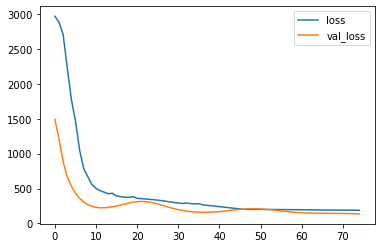

--------------------------------------- Current Engine : 20  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 86ms/step - loss: 2313.4419 - val_loss: 84.0131
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 2253.8835 - val_loss: 97.7233
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 2151.6008 - val_loss: 113.3240
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 2033.3383 - val_loss: 133.8378
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 1929.7217 - val_loss: 162.3863
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 1855.9448 - val_loss: 201.6687
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 1807.3419 - val_loss: 253.2204
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 1772.0503 - val_loss: 315.1294
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 1775.7614 - va

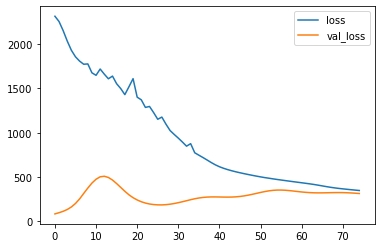

--------------------------------------- Current Engine : 21  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 91ms/step - loss: 2669.4846 - val_loss: 748.4975
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 2547.6545 - val_loss: 596.8975
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 2430.6946 - val_loss: 426.9609
Epoch 4/75
1/1 [==============================] - 0s 52ms/step - loss: 2279.6619 - val_loss: 264.3317
Epoch 5/75
1/1 [==============================] - 0s 63ms/step - loss: 2124.1780 - val_loss: 144.3226
Epoch 6/75
1/1 [==============================] - 0s 55ms/step - loss: 1990.6519 - val_loss: 75.6319
Epoch 7/75
1/1 [==============================] - 0s 53ms/step - loss: 1887.6478 - val_loss: 48.3345
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 1813.3051 - val_loss: 45.2182
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 1760.4294 - val

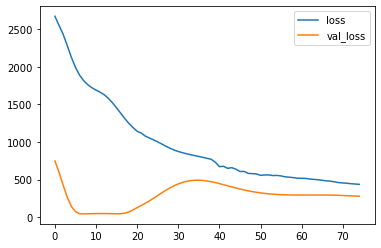

--------------------------------------- Current Engine : 22  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 102ms/step - loss: 2992.6843 - val_loss: 285.4680
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 2740.4932 - val_loss: 360.3353
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 2304.0115 - val_loss: 485.0723
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 2068.7825 - val_loss: 675.1708
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 1420.1946 - val_loss: 942.8564
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 1226.4064 - val_loss: 1280.7802
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 966.4716 - val_loss: 1662.7043
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 1087.0446 - val_loss: 2031.6494
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 954.3732 

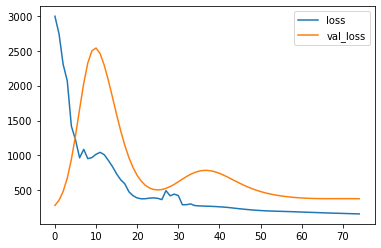

--------------------------------------- Current Engine : 23  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 110ms/step - loss: 1711.9235 - val_loss: 496.8960
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 1654.4897 - val_loss: 458.5271
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 1564.4937 - val_loss: 411.8705
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 1451.6748 - val_loss: 363.4580
Epoch 5/75
1/1 [==============================] - 0s 51ms/step - loss: 1328.9048 - val_loss: 317.7752
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 1208.5024 - val_loss: 277.2899
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 1099.6963 - val_loss: 242.9630
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 1007.7413 - val_loss: 214.8150
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 934.2408 - 

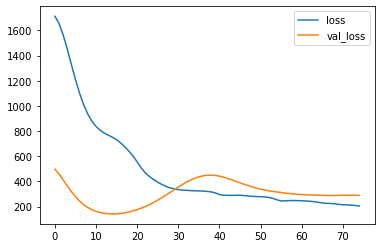

--------------------------------------- Current Engine : 24  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 131ms/step - loss: 1559.2493 - val_loss: 402.6798
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 1348.9017 - val_loss: 387.3118
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 1127.6373 - val_loss: 366.5889
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 986.6796 - val_loss: 344.7675
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 891.4724 - val_loss: 324.4923
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 819.0679 - val_loss: 305.9057
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 765.5919 - val_loss: 288.5784
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 729.6820 - val_loss: 272.3008
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 705.6994 - val_l

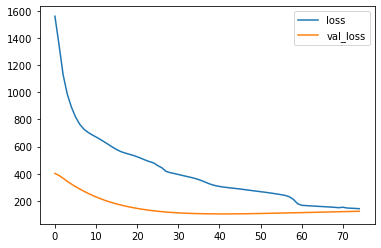

--------------------------------------- Current Engine : 25  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 112ms/step - loss: 5911.5874 - val_loss: 79.6256
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 5860.4019 - val_loss: 79.7365
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 5772.4292 - val_loss: 80.0582
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 5627.2441 - val_loss: 81.0049
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 5444.0615 - val_loss: 83.6080
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 5204.4067 - val_loss: 89.4059
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 4928.7935 - val_loss: 100.0519
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 4675.8066 - val_loss: 117.2026
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 4451.8086 - val_l

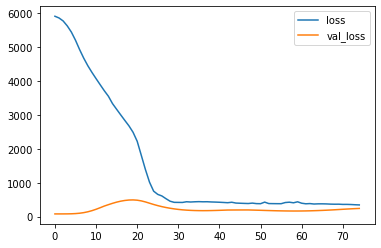

--------------------------------------- Current Engine : 26  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 128ms/step - loss: 338.5491 - val_loss: 315.5739
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 329.4737 - val_loss: 311.4839
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 316.4136 - val_loss: 302.9572
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 298.7291 - val_loss: 290.9866
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 281.2755 - val_loss: 278.5065
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 270.2087 - val_loss: 262.8526
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 241.8059 - val_loss: 246.9054
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 227.8044 - val_loss: 231.4114
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 210.5118 - val_loss

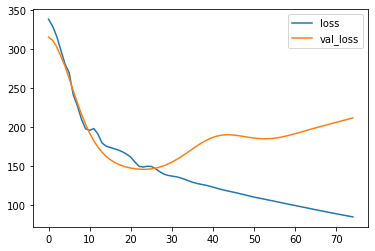

--------------------------------------- Current Engine : 27  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 114ms/step - loss: 2452.1353 - val_loss: 306.0258
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 1972.4160 - val_loss: 283.6621
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 1465.0868 - val_loss: 261.8749
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 1093.5872 - val_loss: 242.7151
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 877.0454 - val_loss: 226.1533
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 760.2000 - val_loss: 211.9648
Epoch 7/75
1/1 [==============================] - ETA: 0s - loss: 631.683 - 0s 46ms/step - loss: 631.6834 - val_loss: 199.8520
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 521.0364 - val_loss: 189.8718
Epoch 9/75
1/1 [==============================] - 0s 47ms/st

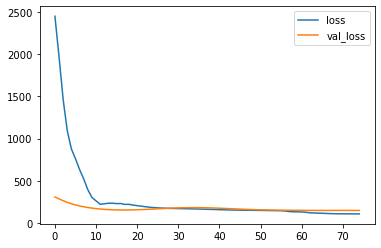

--------------------------------------- Current Engine : 28  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 115ms/step - loss: 1165.3418 - val_loss: 152.1501
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 1130.0723 - val_loss: 151.3435
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 1069.0448 - val_loss: 150.2377
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 991.6691 - val_loss: 148.8579
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 901.7516 - val_loss: 147.2336
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 799.0477 - val_loss: 145.3978
Epoch 7/75
1/1 [==============================] - 0s 58ms/step - loss: 689.1971 - val_loss: 143.3693
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 583.7952 - val_loss: 141.1485
Epoch 9/75
1/1 [==============================] - 0s 61ms/step - loss: 492.8958 - val_l

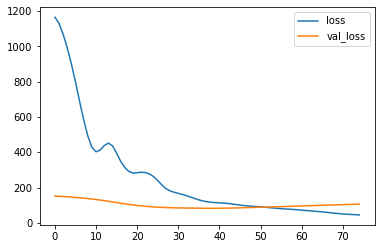

--------------------------------------- Current Engine : 29  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 107ms/step - loss: 2000.2576 - val_loss: 89.9536
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 1879.8138 - val_loss: 93.7221
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 1686.5443 - val_loss: 99.2341
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 1462.1030 - val_loss: 106.6789
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 1217.0371 - val_loss: 116.2424
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 956.9243 - val_loss: 128.1479
Epoch 7/75
1/1 [==============================] - 0s 48ms/step - loss: 717.1497 - val_loss: 142.6488
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 525.3774 - val_loss: 159.9379
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 381.0060 - val_lo

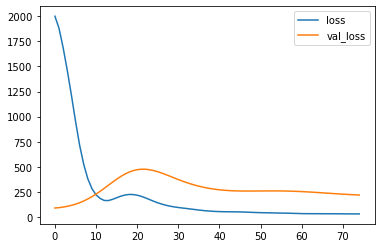

--------------------------------------- Current Engine : 30  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 110ms/step - loss: 1021.9398 - val_loss: 237.0117
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 984.0959 - val_loss: 232.9976
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 926.0096 - val_loss: 228.2906
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 861.4831 - val_loss: 223.0517
Epoch 5/75
1/1 [==============================] - 0s 66ms/step - loss: 790.3066 - val_loss: 217.4606
Epoch 6/75
1/1 [==============================] - 0s 56ms/step - loss: 713.4684 - val_loss: 211.6610
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 647.2564 - val_loss: 205.7353
Epoch 8/75
1/1 [==============================] - 0s 95ms/step - loss: 612.8021 - val_loss: 199.7019
Epoch 9/75
1/1 [==============================] - 0s 109ms/step - loss: 619.5509 - val_lo

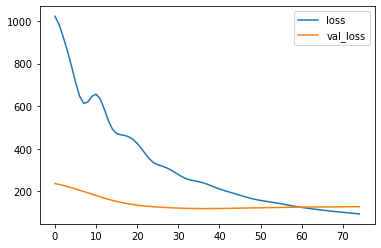

--------------------------------------- Current Engine : 31  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 109ms/step - loss: 1261.1471 - val_loss: 99.6256
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 1094.5684 - val_loss: 99.8867
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 886.9835 - val_loss: 100.3185
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 729.0940 - val_loss: 100.9717
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 643.3795 - val_loss: 101.8894
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 625.1002 - val_loss: 103.0951
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 646.1848 - val_loss: 104.6048
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 675.9714 - val_loss: 106.4208
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 695.4366 - val_loss

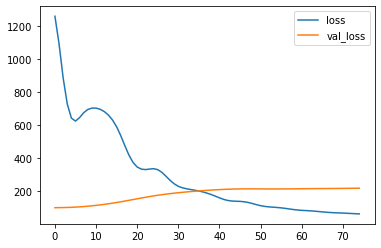

--------------------------------------- Current Engine : 32  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 109ms/step - loss: 2573.8738 - val_loss: 290.8534
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 2410.4490 - val_loss: 321.3693
Epoch 3/75
1/1 [==============================] - 0s 33ms/step - loss: 2262.3101 - val_loss: 368.1598
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 2112.4248 - val_loss: 432.7372
Epoch 5/75
1/1 [==============================] - 0s 54ms/step - loss: 1785.3107 - val_loss: 517.6647
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 1542.2046 - val_loss: 623.7255
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 1352.6503 - val_loss: 747.8296
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 1162.8365 - val_loss: 877.7641
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 1035.4730 -

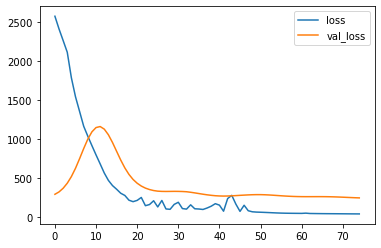

--------------------------------------- Current Engine : 33  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 99ms/step - loss: 2365.6282 - val_loss: 689.0237
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 2222.8359 - val_loss: 605.2677
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 1982.9324 - val_loss: 516.8351
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 1687.0941 - val_loss: 441.9975
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 1390.1145 - val_loss: 385.1146
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 1132.5602 - val_loss: 342.6102
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 910.8617 - val_loss: 310.2200
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 755.0739 - val_loss: 284.5758
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 690.8349 - val

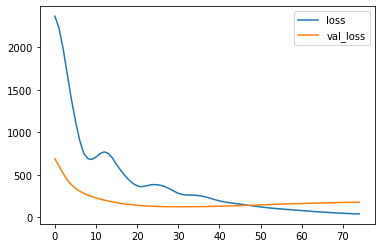

--------------------------------------- Current Engine : 34  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 93ms/step - loss: 2394.8149 - val_loss: 186.4150
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 2222.8652 - val_loss: 193.6098
Epoch 3/75
1/1 [==============================] - 0s 59ms/step - loss: 1925.0226 - val_loss: 204.0273
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 1553.6497 - val_loss: 217.8545
Epoch 5/75
1/1 [==============================] - 0s 31ms/step - loss: 1163.8857 - val_loss: 235.4213
Epoch 6/75
1/1 [==============================] - 0s 63ms/step - loss: 805.7507 - val_loss: 257.2586
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 514.0575 - val_loss: 283.8764
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 294.3057 - val_loss: 315.7102
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 167.3294 - val_

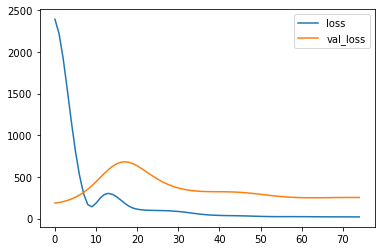

--------------------------------------- Current Engine : 35  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 535.6137 - val_loss: 252.6421
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 496.4711 - val_loss: 249.7543
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 441.2100 - val_loss: 246.0300
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 372.9232 - val_loss: 241.7671
Epoch 5/75
1/1 [==============================] - 0s 55ms/step - loss: 299.7999 - val_loss: 237.2504
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 231.3823 - val_loss: 232.7288
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 176.5702 - val_loss: 228.4072
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 140.3194 - val_loss: 224.4470
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 122.8877 - val_loss

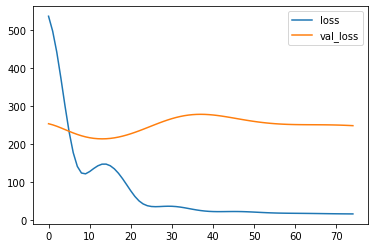

--------------------------------------- Current Engine : 36  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 109ms/step - loss: 119.8087 - val_loss: 279.3008
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 115.7987 - val_loss: 284.4691
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 108.7538 - val_loss: 291.8942
Epoch 4/75
1/1 [==============================] - 0s 54ms/step - loss: 99.9499 - val_loss: 301.0989
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 90.6262 - val_loss: 311.5244
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 81.8085 - val_loss: 322.5226
Epoch 7/75
1/1 [==============================] - 0s 63ms/step - loss: 74.1947 - val_loss: 333.3665
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 68.1202 - val_loss: 343.2836
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 63.5909 - val_loss: 351.

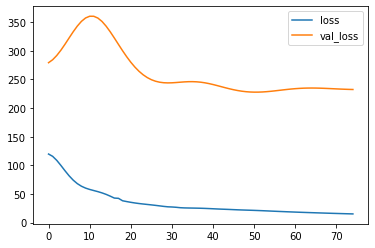

--------------------------------------- Current Engine : 37  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 100ms/step - loss: 786.2018 - val_loss: 232.5189
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 714.3815 - val_loss: 223.8039
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 607.3972 - val_loss: 212.9021
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 491.8887 - val_loss: 201.1391
Epoch 5/75
1/1 [==============================] - 0s 56ms/step - loss: 375.3619 - val_loss: 189.5745
Epoch 6/75
1/1 [==============================] - 0s 27ms/step - loss: 271.0175 - val_loss: 179.0297
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 197.2003 - val_loss: 170.0801
Epoch 8/75
1/1 [==============================] - 0s 82ms/step - loss: 157.6659 - val_loss: 163.0237
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 145.1745 - val_loss

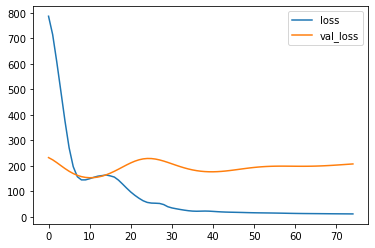

--------------------------------------- Current Engine : 38  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 94ms/step - loss: 1080.3007 - val_loss: 182.7840
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 954.5758 - val_loss: 195.6776
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 824.7067 - val_loss: 214.1270
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 589.0339 - val_loss: 238.3014
Epoch 5/75
1/1 [==============================] - 0s 55ms/step - loss: 420.9915 - val_loss: 268.2216
Epoch 6/75
1/1 [==============================] - 0s 59ms/step - loss: 308.8979 - val_loss: 303.2997
Epoch 7/75
1/1 [==============================] - 0s 49ms/step - loss: 281.1118 - val_loss: 342.3946
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 259.0177 - val_loss: 383.1526
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 231.4680 - val_loss

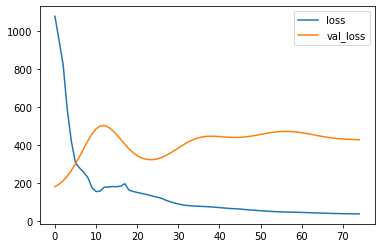

--------------------------------------- Current Engine : 39  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 96ms/step - loss: 1919.6461 - val_loss: 601.7141
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 1761.5914 - val_loss: 528.0064
Epoch 3/75
1/1 [==============================] - 0s 53ms/step - loss: 1489.8082 - val_loss: 449.3274
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 1179.5986 - val_loss: 378.9452
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 882.4753 - val_loss: 322.2573
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 646.8273 - val_loss: 279.5842
Epoch 7/75
1/1 [==============================] - 0s 29ms/step - loss: 494.4645 - val_loss: 249.1195
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 397.9058 - val_loss: 228.7175
Epoch 9/75
1/1 [==============================] - 0s 32ms/step - loss: 334.7094 - val_l

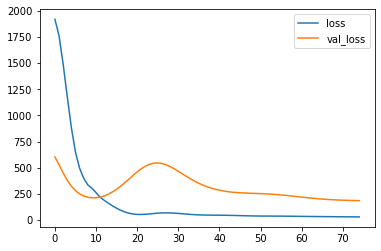

--------------------------------------- Current Engine : 40  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 3057.4883 - val_loss: 144.4532
Epoch 2/75
1/1 [==============================] - 0s 26ms/step - loss: 2852.1213 - val_loss: 175.9998
Epoch 3/75
1/1 [==============================] - 0s 25ms/step - loss: 2530.5735 - val_loss: 234.2822
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 2175.3455 - val_loss: 342.5881
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 1863.0900 - val_loss: 540.5391
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 1642.0465 - val_loss: 844.8594
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 1516.5618 - val_loss: 1222.6647
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 1458.5498 - val_loss: 1615.8510
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 1429.2739 

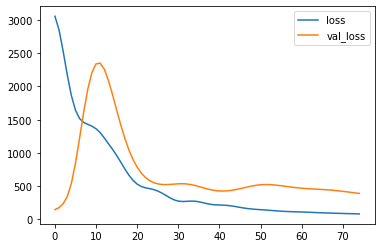

--------------------------------------- Current Engine : 41  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 97ms/step - loss: 1287.0959 - val_loss: 497.1907
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 1227.9561 - val_loss: 463.5659
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 1136.5398 - val_loss: 425.1647
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 1033.3337 - val_loss: 385.7860
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 926.3408 - val_loss: 348.1705
Epoch 6/75
1/1 [==============================] - 0s 52ms/step - loss: 822.3489 - val_loss: 313.9611
Epoch 7/75
1/1 [==============================] - 0s 49ms/step - loss: 721.9771 - val_loss: 283.8700
Epoch 8/75
1/1 [==============================] - 0s 51ms/step - loss: 629.8649 - val_loss: 258.0187
Epoch 9/75
1/1 [==============================] - 0s 53ms/step - loss: 556.4996 - val_l

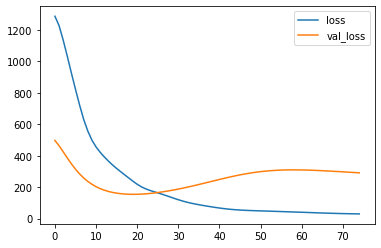

--------------------------------------- Current Engine : 42  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 93.7923 - val_loss: 310.0943
Epoch 2/75
1/1 [==============================] - 0s 54ms/step - loss: 88.4772 - val_loss: 306.9841
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 79.4581 - val_loss: 303.3242
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 68.6012 - val_loss: 299.2632
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 57.7083 - val_loss: 294.9427
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 48.2108 - val_loss: 290.4929
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 40.9984 - val_loss: 286.0303
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 36.3707 - val_loss: 281.6568
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 34.1076 - val_loss: 277.459

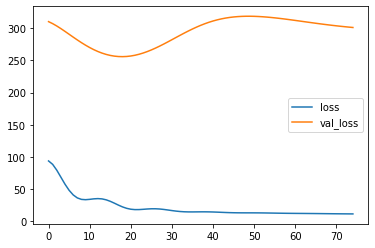

--------------------------------------- Current Engine : 43  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 109ms/step - loss: 448.5709 - val_loss: 299.3605
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 406.8945 - val_loss: 295.7054
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 373.0956 - val_loss: 290.4503
Epoch 4/75
1/1 [==============================] - ETA: 0s - loss: 311.320 - 0s 43ms/step - loss: 311.3203 - val_loss: 283.6968
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 252.5078 - val_loss: 275.8651
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 203.9387 - val_loss: 267.2900
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 170.9512 - val_loss: 258.2536
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 152.0035 - val_loss: 248.9988
Epoch 9/75
1/1 [==============================] - 0s 41ms/step -

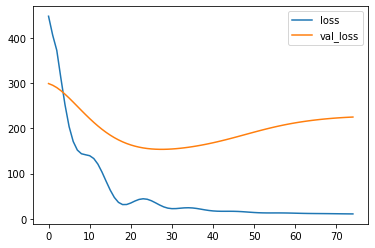

--------------------------------------- Current Engine : 44  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 106ms/step - loss: 68.6517 - val_loss: 247.7080
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 63.2765 - val_loss: 248.6772
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 54.5129 - val_loss: 249.8806
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 44.8438 - val_loss: 251.3223
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 36.3200 - val_loss: 253.0124
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 30.3685 - val_loss: 254.9591
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 27.4260 - val_loss: 257.1648
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 26.9627 - val_loss: 259.6248
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 28.0041 - val_loss: 262.338

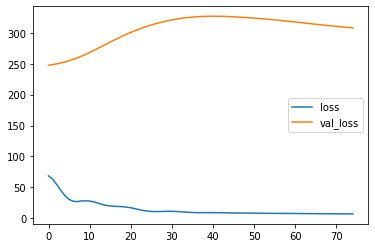

--------------------------------------- Current Engine : 45  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 114ms/step - loss: 1114.7640 - val_loss: 393.6045
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 948.7819 - val_loss: 393.3305
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 707.7838 - val_loss: 393.0645
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 480.7131 - val_loss: 392.6652
Epoch 5/75
1/1 [==============================] - 0s 51ms/step - loss: 299.5429 - val_loss: 392.0045
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 186.9494 - val_loss: 390.9399
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 142.9653 - val_loss: 389.3436
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 145.9320 - val_loss: 387.1371
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 168.1475 - val_los

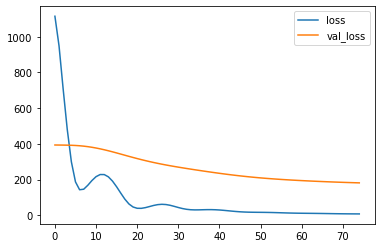

--------------------------------------- Current Engine : 46  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 123ms/step - loss: 3587.4099 - val_loss: 117.9862
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 3300.9893 - val_loss: 118.3829
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 2850.2915 - val_loss: 119.1140
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 2360.5278 - val_loss: 120.2299
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 1916.4037 - val_loss: 121.7939
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 1549.8326 - val_loss: 123.8855
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 1275.7017 - val_loss: 126.6003
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 1089.7441 - val_loss: 130.0571
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 979.8444 - 

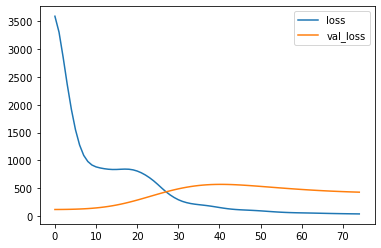

--------------------------------------- Current Engine : 47  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 527.7599 - val_loss: 530.4258
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 461.8900 - val_loss: 527.4011
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 357.6123 - val_loss: 524.0717
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 245.0598 - val_loss: 520.3497
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 150.4635 - val_loss: 516.1349
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 91.2254 - val_loss: 511.3275
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 70.6803 - val_loss: 505.8506
Epoch 8/75
1/1 [==============================] - 0s 31ms/step - loss: 77.6150 - val_loss: 499.6635
Epoch 9/75
1/1 [==============================] - 0s 48ms/step - loss: 99.1565 - val_loss: 49

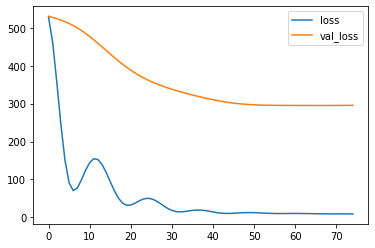

--------------------------------------- Current Engine : 48  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 109ms/step - loss: 256.8130 - val_loss: 405.1247
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 233.7715 - val_loss: 404.1831
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 194.9006 - val_loss: 402.7797
Epoch 4/75
1/1 [==============================] - 0s 55ms/step - loss: 150.7173 - val_loss: 401.0108
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 110.4796 - val_loss: 398.9677
Epoch 6/75
1/1 [==============================] - 0s 56ms/step - loss: 80.7113 - val_loss: 396.7397
Epoch 7/75
1/1 [==============================] - 0s 50ms/step - loss: 64.0868 - val_loss: 394.4298
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 59.1540 - val_loss: 392.1743
Epoch 9/75
1/1 [==============================] - 0s 48ms/step - loss: 62.4600 - val_loss: 39

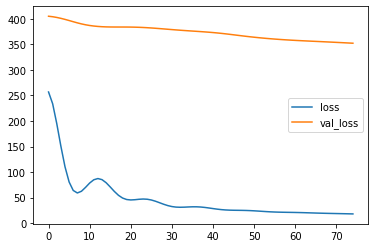

--------------------------------------- Current Engine : 49  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 110ms/step - loss: 543.9722 - val_loss: 279.5714
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 513.6518 - val_loss: 295.0480
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 460.4314 - val_loss: 318.2303
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 392.8080 - val_loss: 349.5251
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 319.7996 - val_loss: 389.3209
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 250.0381 - val_loss: 437.6802
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 190.5233 - val_loss: 494.0124
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 145.6477 - val_loss: 556.7860
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 117.0226 - val_loss

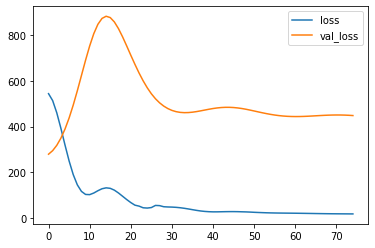

--------------------------------------- Current Engine : 50  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 106ms/step - loss: 172.3550 - val_loss: 479.0648
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 152.0936 - val_loss: 472.6122
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 122.3402 - val_loss: 464.3105
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 94.0279 - val_loss: 454.6797
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 72.6139 - val_loss: 444.1929
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 56.2352 - val_loss: 433.2769
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 43.4190 - val_loss: 422.2993
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 34.4594 - val_loss: 411.5607
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 29.2604 - val_loss: 401.

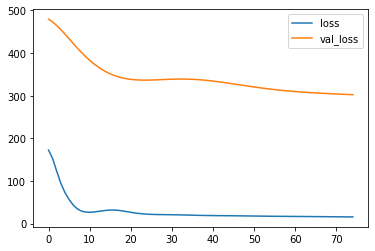

--------------------------------------- Current Engine : 51  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 103ms/step - loss: 798.3895 - val_loss: 785.4893
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 752.0143 - val_loss: 778.8546
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 672.9666 - val_loss: 770.6568
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 577.2322 - val_loss: 761.5508
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 478.8927 - val_loss: 751.9778
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 389.5801 - val_loss: 742.2104
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 317.2483 - val_loss: 732.3927
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 265.1038 - val_loss: 722.5912
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 233.0700 - val_loss

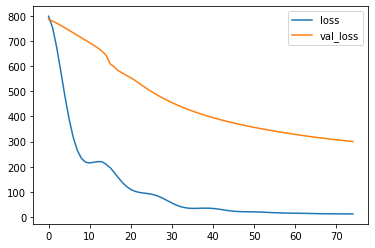

--------------------------------------- Current Engine : 52  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 120ms/step - loss: 236.2401 - val_loss: 212.8825
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 217.4362 - val_loss: 218.0589
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 184.2974 - val_loss: 225.9161
Epoch 4/75
1/1 [==============================] - 0s 56ms/step - loss: 144.0600 - val_loss: 236.3497
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 104.2946 - val_loss: 249.2446
Epoch 6/75
1/1 [==============================] - 0s 54ms/step - loss: 71.7916 - val_loss: 264.4249
Epoch 7/75
1/1 [==============================] - 0s 56ms/step - loss: 51.0283 - val_loss: 281.6031
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 42.9771 - val_loss: 300.3398
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 45.1868 - val_loss: 32

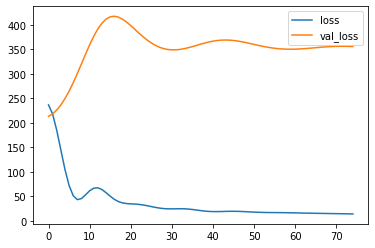

--------------------------------------- Current Engine : 53  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 134ms/step - loss: 180.2335 - val_loss: 446.8501
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 168.4027 - val_loss: 438.6883
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 150.5630 - val_loss: 427.7702
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 129.9046 - val_loss: 414.8853
Epoch 5/75
1/1 [==============================] - 0s 55ms/step - loss: 109.3629 - val_loss: 400.8160
Epoch 6/75
1/1 [==============================] - 0s 57ms/step - loss: 90.4520 - val_loss: 386.2670
Epoch 7/75
1/1 [==============================] - 0s 52ms/step - loss: 74.0849 - val_loss: 371.8132
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 59.7928 - val_loss: 357.8878
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 47.7140 - val_loss: 34

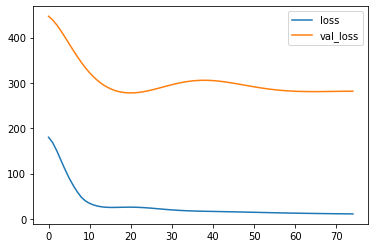

--------------------------------------- Current Engine : 54  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 119ms/step - loss: 482.4672 - val_loss: 202.7120
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 434.7249 - val_loss: 203.7505
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 353.8546 - val_loss: 205.2511
Epoch 4/75
1/1 [==============================] - 0s 48ms/step - loss: 258.9312 - val_loss: 207.1996
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 169.5889 - val_loss: 209.5862
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 104.4582 - val_loss: 212.4002
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 70.3397 - val_loss: 215.6262
Epoch 8/75
1/1 [==============================] - 0s 50ms/step - loss: 62.5838 - val_loss: 219.2445
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 75.2212 - val_loss: 2

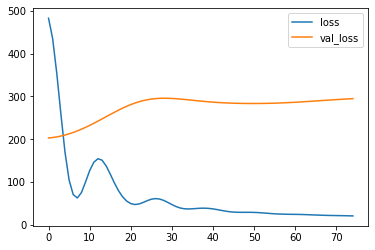

--------------------------------------- Current Engine : 55  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 136ms/step - loss: 650.2706 - val_loss: 417.2250
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 579.2062 - val_loss: 411.2700
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 462.3829 - val_loss: 402.7874
Epoch 4/75
1/1 [==============================] - 0s 48ms/step - loss: 332.4122 - val_loss: 392.3650
Epoch 5/75
1/1 [==============================] - 0s 56ms/step - loss: 216.1134 - val_loss: 380.5695
Epoch 6/75
1/1 [==============================] - 0s 56ms/step - loss: 127.8624 - val_loss: 367.9235
Epoch 7/75
1/1 [==============================] - 0s 56ms/step - loss: 70.1508 - val_loss: 354.8864
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 41.2790 - val_loss: 341.8405
Epoch 9/75
1/1 [==============================] - 0s 53ms/step - loss: 36.6987 - val_loss: 3

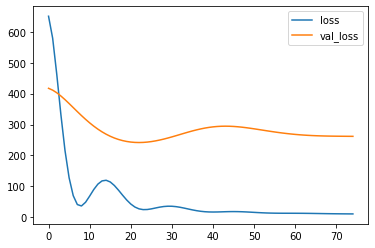

--------------------------------------- Current Engine : 56  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 126ms/step - loss: 6099.0781 - val_loss: 191.0432
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 5660.5391 - val_loss: 222.6108
Epoch 3/75
1/1 [==============================] - 0s 57ms/step - loss: 4956.7417 - val_loss: 283.1595
Epoch 4/75
1/1 [==============================] - 0s 49ms/step - loss: 4105.0942 - val_loss: 394.0461
Epoch 5/75
1/1 [==============================] - 0s 54ms/step - loss: 3224.2610 - val_loss: 587.0350
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 2425.9028 - val_loss: 894.9973
Epoch 7/75
1/1 [==============================] - 0s 57ms/step - loss: 1788.0352 - val_loss: 1330.6121
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 1356.0109 - val_loss: 1866.1820
Epoch 9/75
1/1 [==============================] - 0s 50ms/step - loss: 1146.6880

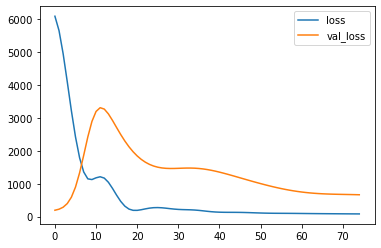

--------------------------------------- Current Engine : 57  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 144ms/step - loss: 21512.1641 - val_loss: 8353.7129
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 20680.5957 - val_loss: 7833.5010
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 19106.5352 - val_loss: 7195.6084
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 17198.9785 - val_loss: 6530.0967
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 15258.3037 - val_loss: 5817.8711
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 13821.5518 - val_loss: 5167.0259
Epoch 7/75
1/1 [==============================] - 0s 31ms/step - loss: 12495.9785 - val_loss: 4581.7261
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 11310.4277 - val_loss: 4052.3113
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - l

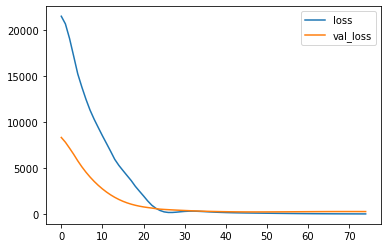

--------------------------------------- Current Engine : 58  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 129ms/step - loss: 303.4089 - val_loss: 273.0249
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 278.1467 - val_loss: 271.3232
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 236.3815 - val_loss: 269.4357
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 189.2598 - val_loss: 267.4870
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 147.5440 - val_loss: 265.6020
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 117.5848 - val_loss: 263.8928
Epoch 7/75
1/1 [==============================] - 0s 57ms/step - loss: 100.0252 - val_loss: 262.4492
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 92.5528 - val_loss: 261.3382
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 92.3662 - val_loss: 

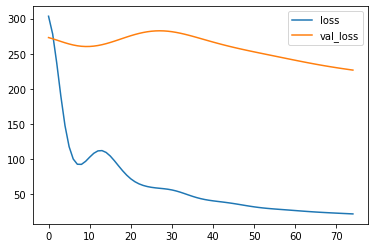

--------------------------------------- Current Engine : 59  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 135ms/step - loss: 1792.2654 - val_loss: 138.3981
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 1777.0936 - val_loss: 139.1612
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 1752.9490 - val_loss: 140.4692
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 1722.9099 - val_loss: 142.2881
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 1689.0944 - val_loss: 144.5911
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 1653.2319 - val_loss: 147.3552
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 1616.6417 - val_loss: 150.5579
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 1580.2166 - val_loss: 154.1748
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 1544.5304 -

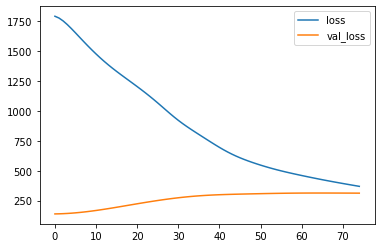

--------------------------------------- Current Engine : 60  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 144ms/step - loss: 364.9395 - val_loss: 393.9650
Epoch 2/75
1/1 [==============================] - 0s 53ms/step - loss: 283.1265 - val_loss: 393.6446
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 237.5843 - val_loss: 393.2477
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 186.0950 - val_loss: 392.8288
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 153.6946 - val_loss: 392.5652
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 112.5475 - val_loss: 392.5354
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 94.3836 - val_loss: 392.8104
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 92.0715 - val_loss: 393.4724
Epoch 9/75
1/1 [==============================] - 0s 53ms/step - loss: 99.3352 - val_loss: 3

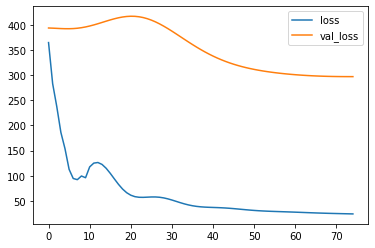

--------------------------------------- Current Engine : 61  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 112ms/step - loss: 1398.1410 - val_loss: 343.0000
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 1320.9232 - val_loss: 341.7521
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 1188.2761 - val_loss: 339.9236
Epoch 4/75
1/1 [==============================] - 0s 54ms/step - loss: 1016.9692 - val_loss: 337.5363
Epoch 5/75
1/1 [==============================] - 0s 50ms/step - loss: 817.0696 - val_loss: 334.6323
Epoch 6/75
1/1 [==============================] - 0s 52ms/step - loss: 606.0154 - val_loss: 331.1917
Epoch 7/75
1/1 [==============================] - 0s 50ms/step - loss: 414.9089 - val_loss: 327.1505
Epoch 8/75
1/1 [==============================] - 0s 50ms/step - loss: 266.7437 - val_loss: 322.4217
Epoch 9/75
1/1 [==============================] - 0s 50ms/step - loss: 179.0669 - val_

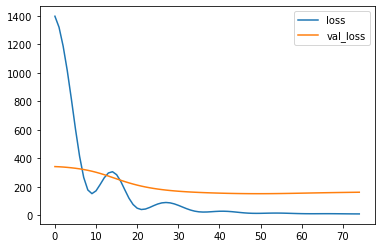

--------------------------------------- Current Engine : 62  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 126ms/step - loss: 2454.8401 - val_loss: 171.8041
Epoch 2/75
1/1 [==============================] - 0s 49ms/step - loss: 2331.4087 - val_loss: 188.2311
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 2122.7732 - val_loss: 213.3127
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 1861.7697 - val_loss: 249.2621
Epoch 5/75
1/1 [==============================] - 0s 54ms/step - loss: 1579.9568 - val_loss: 299.8305
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 1308.6926 - val_loss: 370.8313
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 1072.6328 - val_loss: 469.6865
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 885.5063 - val_loss: 602.7704
Epoch 9/75
1/1 [==============================] - 0s 53ms/step - loss: 742.9131 - v

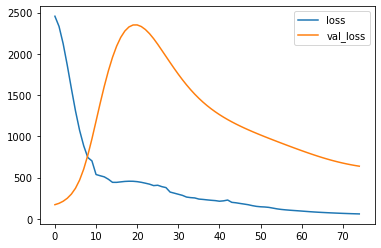

--------------------------------------- Current Engine : 63  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 134ms/step - loss: 406.3579 - val_loss: 675.0101
Epoch 2/75
1/1 [==============================] - 0s 53ms/step - loss: 371.6451 - val_loss: 643.1219
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 313.8396 - val_loss: 620.9282
Epoch 4/75
1/1 [==============================] - 0s 55ms/step - loss: 246.1259 - val_loss: 601.5682
Epoch 5/75
1/1 [==============================] - 0s 52ms/step - loss: 180.6389 - val_loss: 583.1330
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 125.6325 - val_loss: 565.8819
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 85.2028 - val_loss: 550.2047
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 60.1767 - val_loss: 536.3390
Epoch 9/75
1/1 [==============================] - 0s 53ms/step - loss: 49.8342 - val_loss: 5

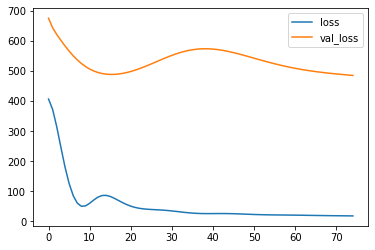

--------------------------------------- Current Engine : 64  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 142ms/step - loss: 6205.5015 - val_loss: 278.4496
Epoch 2/75
1/1 [==============================] - 0s 77ms/step - loss: 5964.4243 - val_loss: 284.7126
Epoch 3/75
1/1 [==============================] - 0s 62ms/step - loss: 5557.5239 - val_loss: 294.3283
Epoch 4/75
1/1 [==============================] - 0s 55ms/step - loss: 5045.2310 - val_loss: 307.5393
Epoch 5/75
1/1 [==============================] - 0s 54ms/step - loss: 4492.2803 - val_loss: 324.7226
Epoch 6/75
1/1 [==============================] - 0s 59ms/step - loss: 3960.2295 - val_loss: 346.3794
Epoch 7/75
1/1 [==============================] - 0s 59ms/step - loss: 3456.5083 - val_loss: 373.0681
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 3010.6541 - val_loss: 405.3026
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 2616.5149 -

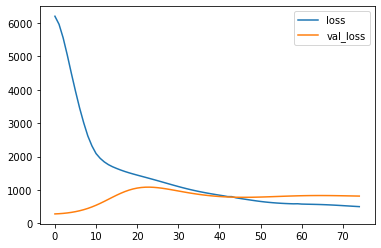

--------------------------------------- Current Engine : 65  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 122ms/step - loss: 15861.9678 - val_loss: 2534.7463
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 15446.4834 - val_loss: 2460.5593
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 14822.1377 - val_loss: 2364.7861
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 14138.6875 - val_loss: 2254.9104
Epoch 5/75
1/1 [==============================] - 0s 50ms/step - loss: 13466.8145 - val_loss: 2137.7124
Epoch 6/75
1/1 [==============================] - 0s 50ms/step - loss: 12817.7021 - val_loss: 2018.8254
Epoch 7/75
1/1 [==============================] - 0s 58ms/step - loss: 12190.2568 - val_loss: 1902.5886
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 11579.4170 - val_loss: 1792.0710
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - l

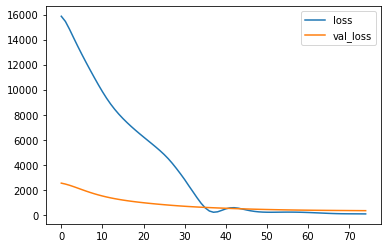

--------------------------------------- Current Engine : 66  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 6405.1807 - val_loss: 259.5399
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 5995.3584 - val_loss: 275.9403
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 5423.4756 - val_loss: 299.1577
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 4797.1323 - val_loss: 329.5403
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 4247.4717 - val_loss: 367.7460
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 3812.6670 - val_loss: 413.8833
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 3458.2195 - val_loss: 466.8594
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 3135.2229 - val_loss: 525.0450
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 2875.4353 - 

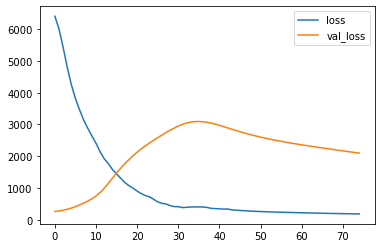

--------------------------------------- Current Engine : 67  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 121ms/step - loss: 7420.0781 - val_loss: 1494.9906
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 7234.9980 - val_loss: 1497.2032
Epoch 3/75
1/1 [==============================] - 0s 53ms/step - loss: 7017.6382 - val_loss: 1505.6753
Epoch 4/75
1/1 [==============================] - 0s 49ms/step - loss: 6610.8491 - val_loss: 1519.5795
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 6290.5342 - val_loss: 1538.1158
Epoch 6/75
1/1 [==============================] - 0s 55ms/step - loss: 5994.2832 - val_loss: 1560.7694
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 5743.5928 - val_loss: 1587.4513
Epoch 8/75
1/1 [==============================] - 0s 59ms/step - loss: 5414.0781 - val_loss: 1616.4908
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 524

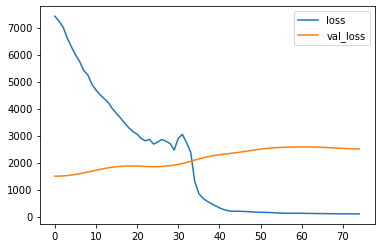

--------------------------------------- Current Engine : 68  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 76ms/step - loss: 9143.0947 - val_loss: 3442.7622
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 6943.1558 - val_loss: 3326.6421
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 4119.4990 - val_loss: 3198.4067
Epoch 4/75
1/1 [==============================] - 0s 34ms/step - loss: 1877.2593 - val_loss: 3071.1118
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 805.1909 - val_loss: 2951.8069
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 347.3872 - val_loss: 2843.6479
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 238.1311 - val_loss: 2747.3723
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 301.0536 - val_loss: 2663.2390
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 431.0177

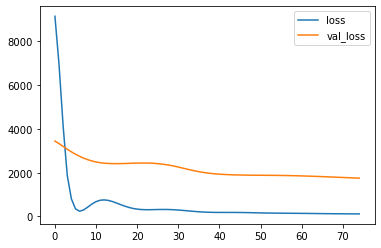

--------------------------------------- Current Engine : 69  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 82ms/step - loss: 9045.2383 - val_loss: 1059.2621
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 8680.8877 - val_loss: 1083.4261
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 8079.4990 - val_loss: 1119.2965
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 7346.5537 - val_loss: 1166.2220
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 6565.8159 - val_loss: 1224.1863
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 5797.6021 - val_loss: 1293.6400
Epoch 7/75
1/1 [==============================] - 0s 48ms/step - loss: 5081.7241 - val_loss: 1375.1193
Epoch 8/75
1/1 [==============================] - 0s 64ms/step - loss: 4441.3379 - val_loss: 1468.6127
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 3885

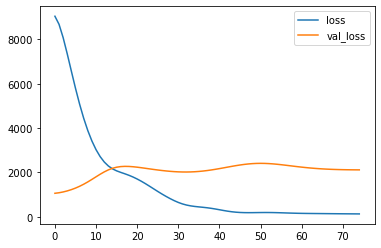

--------------------------------------- Current Engine : 70  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 111ms/step - loss: 20489.5098 - val_loss: 4059.9031
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 18128.8730 - val_loss: 4625.5718
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 15241.7402 - val_loss: 6492.6460
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 12356.3828 - val_loss: 3572.8857
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 9571.1592 - val_loss: 3354.9663
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 6972.7617 - val_loss: 3178.2625
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 4675.6855 - val_loss: 3019.5464
Epoch 8/75
1/1 [==============================] - 0s 51ms/step - loss: 2831.9004 - val_loss: 2875.7788
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss:

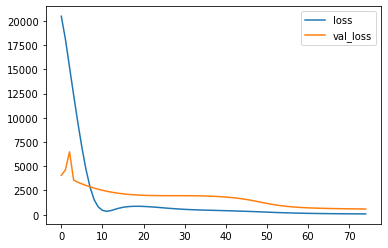

--------------------------------------- Current Engine : 71  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 126ms/step - loss: 1843.8391 - val_loss: 378.8034
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 1652.7085 - val_loss: 383.9763
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 1525.8470 - val_loss: 392.2772
Epoch 4/75
1/1 [==============================] - 0s 56ms/step - loss: 1237.0306 - val_loss: 404.1271
Epoch 5/75
1/1 [==============================] - 0s 52ms/step - loss: 1073.7809 - val_loss: 419.5902
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 916.5074 - val_loss: 440.3960
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 814.5999 - val_loss: 466.0652
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 929.2844 - val_loss: 495.4931
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 986.1919 - val

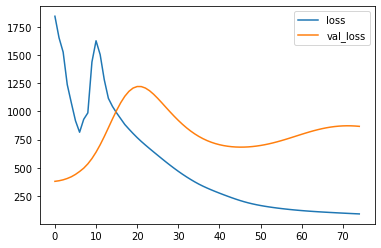

--------------------------------------- Current Engine : 72  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 115ms/step - loss: 571.4060 - val_loss: 907.0635
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 557.2704 - val_loss: 889.6590
Epoch 3/75
1/1 [==============================] - 0s 58ms/step - loss: 533.4424 - val_loss: 866.3233
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 501.9983 - val_loss: 838.9948
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 465.1008 - val_loss: 809.4665
Epoch 6/75
1/1 [==============================] - 0s 57ms/step - loss: 424.9167 - val_loss: 779.2583
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 383.5542 - val_loss: 749.5684
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 343.0009 - val_loss: 721.2776
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 305.0501 - val_loss

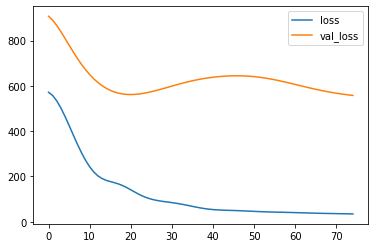

--------------------------------------- Current Engine : 73  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 96ms/step - loss: 2299.6953 - val_loss: 544.7894
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 2064.4053 - val_loss: 572.4949
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 1731.3118 - val_loss: 614.5741
Epoch 4/75
1/1 [==============================] - 0s 53ms/step - loss: 1368.1484 - val_loss: 672.6844
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 928.9316 - val_loss: 749.3104
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 607.5394 - val_loss: 846.4233
Epoch 7/75
1/1 [==============================] - 0s 51ms/step - loss: 317.5024 - val_loss: 965.1922
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 253.8174 - val_loss: 1106.9344
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 150.5280 - val_

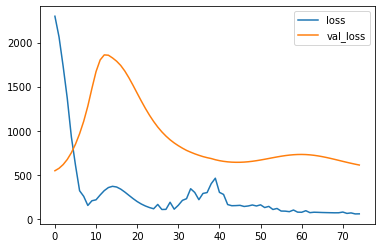

--------------------------------------- Current Engine : 74  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 105ms/step - loss: 2471.8074 - val_loss: 1024.5792
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 2358.0410 - val_loss: 976.5163
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 2177.6724 - val_loss: 921.2520
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 1935.4037 - val_loss: 862.7502
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 1653.2577 - val_loss: 804.2604
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 1359.1622 - val_loss: 748.1274
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 1077.7578 - val_loss: 695.8457
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 830.1565 - val_loss: 648.2141
Epoch 9/75
1/1 [==============================] - 0s 50ms/step - loss: 629.9110 - 

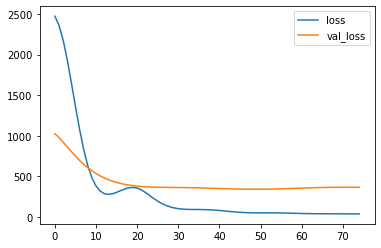

--------------------------------------- Current Engine : 75  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 115ms/step - loss: 1557.8539 - val_loss: 245.1485
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 1462.7449 - val_loss: 252.3924
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 1300.1428 - val_loss: 262.6323
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 1098.8157 - val_loss: 275.5039
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 896.4413 - val_loss: 290.6873
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 702.9268 - val_loss: 307.9757
Epoch 7/75
1/1 [==============================] - 0s 48ms/step - loss: 529.9565 - val_loss: 327.2463
Epoch 8/75
1/1 [==============================] - 0s 54ms/step - loss: 387.1045 - val_loss: 348.4577
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 277.1111 - val_

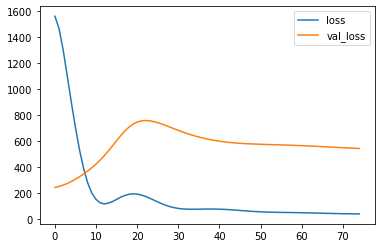

--------------------------------------- Current Engine : 76  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 75ms/step - loss: 122.5778 - val_loss: 575.0059
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 119.1787 - val_loss: 576.2750
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 113.4243 - val_loss: 578.6262
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 107.6625 - val_loss: 581.9099
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 101.3116 - val_loss: 585.9774
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 93.5914 - val_loss: 590.6893
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 86.7214 - val_loss: 595.9030
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 80.5693 - val_loss: 601.4700
Epoch 9/75
1/1 [==============================] - 0s 52ms/step - loss: 75.2902 - val_loss: 607

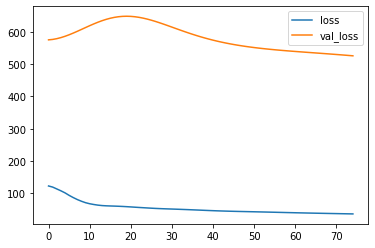

--------------------------------------- Current Engine : 77  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 94ms/step - loss: 3806.4871 - val_loss: 828.7406
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 3434.5312 - val_loss: 800.0635
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 2935.4143 - val_loss: 766.3020
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 2374.5671 - val_loss: 730.6921
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 1819.7440 - val_loss: 695.0750
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 1313.6882 - val_loss: 660.8151
Epoch 7/75
1/1 [==============================] - 0s 50ms/step - loss: 986.6082 - val_loss: 628.3422
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 753.9698 - val_loss: 594.4617
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 476.8335 - val

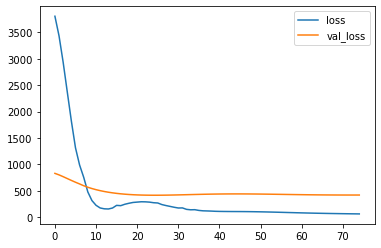

--------------------------------------- Current Engine : 78  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 88ms/step - loss: 778.3785 - val_loss: 286.1130
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 737.4560 - val_loss: 287.3445
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 668.1235 - val_loss: 289.0160
Epoch 4/75
1/1 [==============================] - 0s 52ms/step - loss: 578.4738 - val_loss: 291.0431
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 476.9901 - val_loss: 293.3386
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 372.3591 - val_loss: 295.8131
Epoch 7/75
1/1 [==============================] - 0s 51ms/step - loss: 272.9246 - val_loss: 298.3761
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 186.2468 - val_loss: 300.9349
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 119.0296 - val_loss:

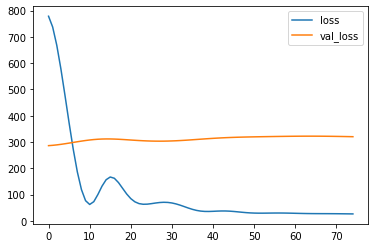

--------------------------------------- Current Engine : 79  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 131ms/step - loss: 248.0668 - val_loss: 378.7623
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 231.4081 - val_loss: 376.3486
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 204.6799 - val_loss: 373.1754
Epoch 4/75
1/1 [==============================] - 0s 58ms/step - loss: 173.2217 - val_loss: 369.4275
Epoch 5/75
1/1 [==============================] - 0s 57ms/step - loss: 141.8898 - val_loss: 365.2814
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 114.2243 - val_loss: 360.8983
Epoch 7/75
1/1 [==============================] - 0s 52ms/step - loss: 92.1929 - val_loss: 356.4196
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 76.4032 - val_loss: 351.9646
Epoch 9/75
1/1 [==============================] - 0s 59ms/step - loss: 66.5355 - val_loss: 3

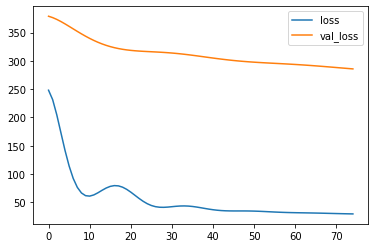

--------------------------------------- Current Engine : 80  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 147ms/step - loss: 1782.9152 - val_loss: 304.5169
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 1686.6421 - val_loss: 313.3132
Epoch 3/75
1/1 [==============================] - 0s 70ms/step - loss: 1522.6530 - val_loss: 325.6943
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 1322.4141 - val_loss: 341.3027
Epoch 5/75
1/1 [==============================] - 0s 58ms/step - loss: 1113.1346 - val_loss: 360.0077
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 914.3027 - val_loss: 381.8320
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 737.2991 - val_loss: 406.8648
Epoch 8/75
1/1 [==============================] - 0s 57ms/step - loss: 587.3013 - val_loss: 435.1653
Epoch 9/75
1/1 [==============================] - 0s 68ms/step - loss: 465.4810 - val

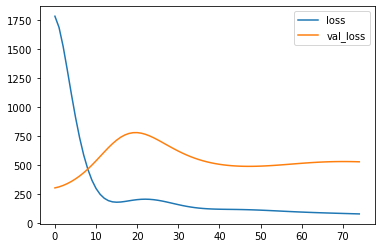

--------------------------------------- Current Engine : 81  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 133ms/step - loss: 1762.0321 - val_loss: 399.3373
Epoch 2/75
1/1 [==============================] - 0s 61ms/step - loss: 1718.9778 - val_loss: 405.5592
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 1640.0555 - val_loss: 414.7679
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 1535.0997 - val_loss: 426.7562
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 1413.9277 - val_loss: 441.3247
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 1285.3557 - val_loss: 458.2528
Epoch 7/75
1/1 [==============================] - 0s 58ms/step - loss: 1156.6318 - val_loss: 477.2684
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 1033.2094 - val_loss: 498.0230
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 918.7917 - 

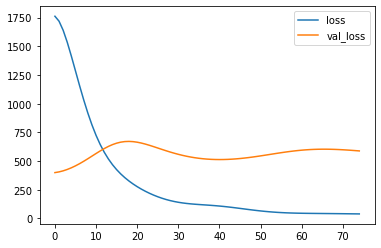

--------------------------------------- Current Engine : 82  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 132ms/step - loss: 3797.9221 - val_loss: 1088.7841
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 3568.3892 - val_loss: 1047.6295
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 3195.1475 - val_loss: 995.4880
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 2761.7874 - val_loss: 936.8883
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 2325.4216 - val_loss: 875.6008
Epoch 6/75
1/1 [==============================] - 0s 55ms/step - loss: 1913.9384 - val_loss: 814.4900
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 1539.7682 - val_loss: 755.5647
Epoch 8/75
1/1 [==============================] - 0s 51ms/step - loss: 1211.9838 - val_loss: 700.1282
Epoch 9/75
1/1 [==============================] - 0s 61ms/step - loss: 939.6725 

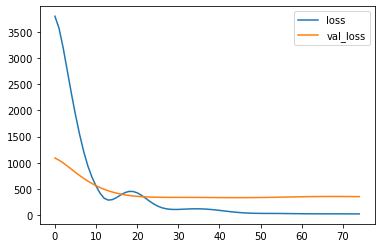

--------------------------------------- Current Engine : 83  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 120ms/step - loss: 2679.2942 - val_loss: 245.7307
Epoch 2/75
1/1 [==============================] - 0s 49ms/step - loss: 2536.5032 - val_loss: 248.7689
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 2279.7920 - val_loss: 253.2407
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 1948.1354 - val_loss: 258.9798
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 1579.1517 - val_loss: 265.8207
Epoch 6/75
1/1 [==============================] - 0s 70ms/step - loss: 1214.0880 - val_loss: 273.5894
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 889.0370 - val_loss: 282.0961
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 618.9460 - val_loss: 291.1292
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 407.0942 - va

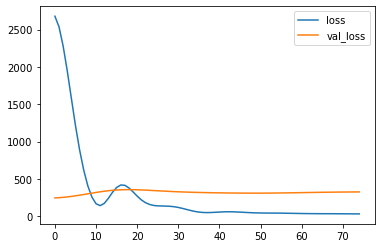

--------------------------------------- Current Engine : 84  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 129ms/step - loss: 3867.9397 - val_loss: 343.7848
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 3725.0706 - val_loss: 361.0862
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 3478.7712 - val_loss: 387.2242
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 3159.6699 - val_loss: 424.0257
Epoch 5/75
1/1 [==============================] - 0s 67ms/step - loss: 2797.1934 - val_loss: 474.9026
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 2424.5078 - val_loss: 545.3014
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 2063.9189 - val_loss: 642.6530
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 1729.7310 - val_loss: 774.5261
Epoch 9/75
1/1 [==============================] - 0s 79ms/step - loss: 1434.5465 -

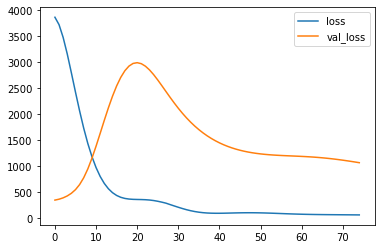

--------------------------------------- Current Engine : 85  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 142ms/step - loss: 9283.1865 - val_loss: 1982.9827
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 8905.4355 - val_loss: 1897.4540
Epoch 3/75
1/1 [==============================] - 0s 67ms/step - loss: 8277.2158 - val_loss: 1792.8232
Epoch 4/75
1/1 [==============================] - 0s 70ms/step - loss: 7502.0576 - val_loss: 1678.7943
Epoch 5/75
1/1 [==============================] - 0s 54ms/step - loss: 6656.4971 - val_loss: 1562.9784
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 5856.0220 - val_loss: 1450.6432
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 5087.5273 - val_loss: 1344.7953
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 4375.1133 - val_loss: 1247.0580
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 371

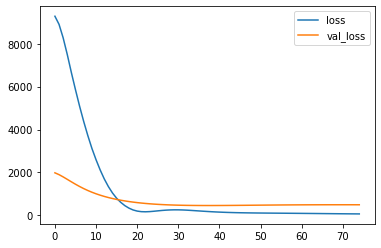

--------------------------------------- Current Engine : 86  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 84ms/step - loss: 6448.0806 - val_loss: 305.0562
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 6309.5913 - val_loss: 314.1605
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 6051.7476 - val_loss: 327.8541
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 5710.2661 - val_loss: 346.4536
Epoch 5/75
1/1 [==============================] - 0s 50ms/step - loss: 5318.4268 - val_loss: 370.4628
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 4903.9702 - val_loss: 400.4997
Epoch 7/75
1/1 [==============================] - 0s 104ms/step - loss: 4488.1011 - val_loss: 437.2069
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 4085.8794 - val_loss: 481.1438
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 3706.9905 -

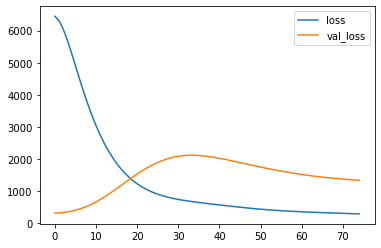

--------------------------------------- Current Engine : 87  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 246ms/step - loss: 5677.9448 - val_loss: 1915.2882
Epoch 2/75
1/1 [==============================] - 0s 73ms/step - loss: 5599.1211 - val_loss: 1873.9279
Epoch 3/75
1/1 [==============================] - 0s 87ms/step - loss: 5449.5859 - val_loss: 1821.6165
Epoch 4/75
1/1 [==============================] - 0s 80ms/step - loss: 5241.2051 - val_loss: 1761.2073
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 4985.7852 - val_loss: 1695.3002
Epoch 6/75
1/1 [==============================] - 0s 74ms/step - loss: 4694.6089 - val_loss: 1626.1534
Epoch 7/75
1/1 [==============================] - 0s 64ms/step - loss: 4378.1196 - val_loss: 1555.6517
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 4045.7539 - val_loss: 1485.3173
Epoch 9/75
1/1 [==============================] - 0s 60ms/step - loss: 370

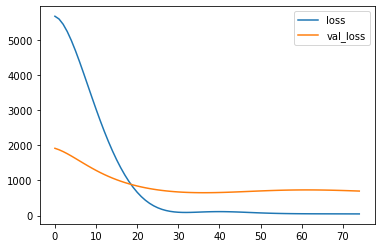

--------------------------------------- Current Engine : 88  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 134ms/step - loss: 267.6367 - val_loss: 611.0280
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 262.9332 - val_loss: 608.1294
Epoch 3/75
1/1 [==============================] - 0s 51ms/step - loss: 255.3382 - val_loss: 605.6843
Epoch 4/75
1/1 [==============================] - 0s 29ms/step - loss: 245.3768 - val_loss: 603.6364
Epoch 5/75
1/1 [==============================] - 0s 62ms/step - loss: 233.5841 - val_loss: 601.9316
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 220.4741 - val_loss: 600.5203
Epoch 7/75
1/1 [==============================] - 0s 130ms/step - loss: 206.5227 - val_loss: 599.3552
Epoch 8/75
1/1 [==============================] - 0s 122ms/step - loss: 192.1521 - val_loss: 598.3928
Epoch 9/75
1/1 [==============================] - 0s 63ms/step - loss: 177.7244 - val_lo

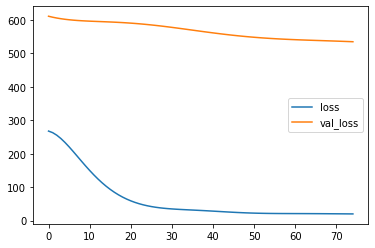

--------------------------------------- Current Engine : 89  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 218ms/step - loss: 342.1826 - val_loss: 535.3049
Epoch 2/75
1/1 [==============================] - 0s 64ms/step - loss: 336.6987 - val_loss: 532.9454
Epoch 3/75
1/1 [==============================] - 0s 51ms/step - loss: 325.6498 - val_loss: 529.8185
Epoch 4/75
1/1 [==============================] - 0s 63ms/step - loss: 310.2313 - val_loss: 526.0450
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 291.6915 - val_loss: 521.7417
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 271.2209 - val_loss: 517.0197
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 249.8708 - val_loss: 511.9819
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 228.5076 - val_loss: 506.7227
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 207.7949 - val_loss

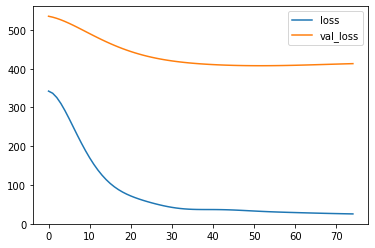

--------------------------------------- Current Engine : 90  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 143ms/step - loss: 3038.3633 - val_loss: 637.5637
Epoch 2/75
1/1 [==============================] - 0s 60ms/step - loss: 2828.8367 - val_loss: 631.1815
Epoch 3/75
1/1 [==============================] - 0s 101ms/step - loss: 2487.8877 - val_loss: 622.2571
Epoch 4/75
1/1 [==============================] - 0s 83ms/step - loss: 2097.7209 - val_loss: 611.4020
Epoch 5/75
1/1 [==============================] - 0s 62ms/step - loss: 1719.8849 - val_loss: 599.1687
Epoch 6/75
1/1 [==============================] - 0s 78ms/step - loss: 1387.1394 - val_loss: 586.0311
Epoch 7/75
1/1 [==============================] - 0s 84ms/step - loss: 1108.2188 - val_loss: 572.3817
Epoch 8/75
1/1 [==============================] - 0s 106ms/step - loss: 879.6115 - val_loss: 558.5353
Epoch 9/75
1/1 [==============================] - 0s 81ms/step - loss: 694.4639 -

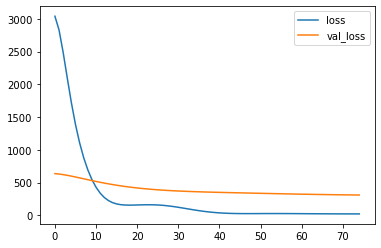

--------------------------------------- Current Engine : 91  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 146ms/step - loss: 1034.9937 - val_loss: 347.9499
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 970.1331 - val_loss: 355.8473
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 904.2786 - val_loss: 366.3344
Epoch 4/75
1/1 [==============================] - 0s 48ms/step - loss: 827.9555 - val_loss: 378.5193
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 742.4412 - val_loss: 391.6857
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 655.3652 - val_loss: 405.3192
Epoch 7/75
1/1 [==============================] - 0s 51ms/step - loss: 567.9520 - val_loss: 419.0775
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 483.7050 - val_loss: 432.8069
Epoch 9/75
1/1 [==============================] - 0s 57ms/step - loss: 408.9809 - val_los

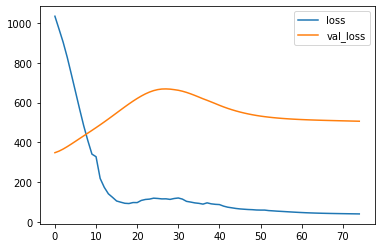

--------------------------------------- Current Engine : 92  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 247ms/step - loss: 17902.0078 - val_loss: 236.8152
Epoch 2/75
1/1 [==============================] - 0s 64ms/step - loss: 17595.6250 - val_loss: 239.1375
Epoch 3/75
1/1 [==============================] - 0s 68ms/step - loss: 17056.2031 - val_loss: 242.7699
Epoch 4/75
1/1 [==============================] - 0s 91ms/step - loss: 16343.9229 - val_loss: 247.9607
Epoch 5/75
1/1 [==============================] - 0s 62ms/step - loss: 15512.8252 - val_loss: 255.1145
Epoch 6/75
1/1 [==============================] - 0s 91ms/step - loss: 14610.6338 - val_loss: 264.8118
Epoch 7/75
1/1 [==============================] - 0s 82ms/step - loss: 13677.0840 - val_loss: 277.8121
Epoch 8/75
1/1 [==============================] - 0s 108ms/step - loss: 12743.1387 - val_loss: 295.0155
Epoch 9/75
1/1 [==============================] - 0s 86ms/step - loss: 11

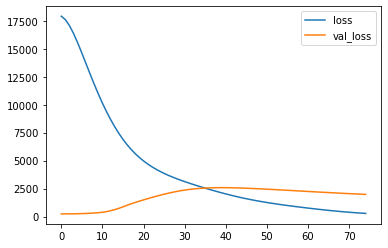

--------------------------------------- Current Engine : 93  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 23804.2188 - val_loss: 3496.4351
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 23117.9570 - val_loss: 3411.1174
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 21859.1016 - val_loss: 3305.3396
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 20281.2207 - val_loss: 3185.1326
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 18560.9238 - val_loss: 3055.6655
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 16792.6973 - val_loss: 2921.2390
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 14975.9590 - val_loss: 2785.3118
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 13036.3008 - val_loss: 2650.5125
Epoch 9/75
1/1 [==============================] - 0s 66ms/step - lo

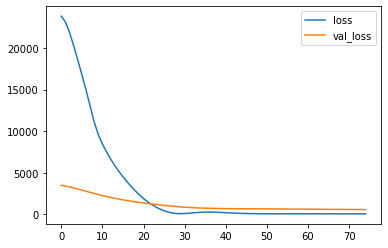

--------------------------------------- Current Engine : 94  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 88ms/step - loss: 7782.6040 - val_loss: 336.4943
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 7560.0269 - val_loss: 343.5157
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 7174.0107 - val_loss: 354.6863
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 6692.2188 - val_loss: 370.9619
Epoch 5/75
1/1 [==============================] - 0s 64ms/step - loss: 6152.4634 - val_loss: 393.8915
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 5678.8193 - val_loss: 425.6435
Epoch 7/75
1/1 [==============================] - 0s 52ms/step - loss: 5199.6362 - val_loss: 468.8676
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 4756.9180 - val_loss: 526.2489
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 4385.7319 - 

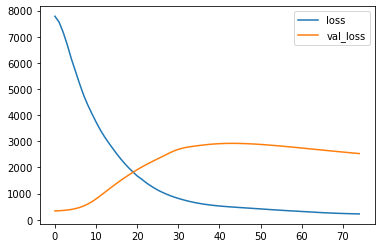

--------------------------------------- Current Engine : 95  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 113ms/step - loss: 2131.2942 - val_loss: 2453.3391
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 2109.5935 - val_loss: 2441.9355
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 2070.8347 - val_loss: 2431.8013
Epoch 4/75
1/1 [==============================] - 0s 77ms/step - loss: 2018.2242 - val_loss: 2422.8035
Epoch 5/75
1/1 [==============================] - 0s 58ms/step - loss: 1954.8511 - val_loss: 2414.8130
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 1883.5300 - val_loss: 2407.7090
Epoch 7/75
1/1 [==============================] - 0s 58ms/step - loss: 1806.6202 - val_loss: 2401.3745
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 1725.8485 - val_loss: 2395.6997
Epoch 9/75
1/1 [==============================] - 0s 54ms/step - loss: 164

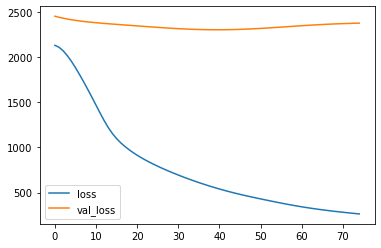

--------------------------------------- Current Engine : 96  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 242ms/step - loss: 3221.7642 - val_loss: 2064.0598
Epoch 2/75
1/1 [==============================] - 0s 68ms/step - loss: 3123.8833 - val_loss: 2074.0220
Epoch 3/75
1/1 [==============================] - 0s 100ms/step - loss: 2955.7859 - val_loss: 2087.9570
Epoch 4/75
1/1 [==============================] - 0s 61ms/step - loss: 2742.0430 - val_loss: 2105.7139
Epoch 5/75
1/1 [==============================] - 0s 70ms/step - loss: 2505.9026 - val_loss: 2127.1853
Epoch 6/75
1/1 [==============================] - 0s 55ms/step - loss: 2266.6821 - val_loss: 2152.2952
Epoch 7/75
1/1 [==============================] - 0s 48ms/step - loss: 2038.5883 - val_loss: 2180.9644
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 1830.8489 - val_loss: 2212.9470
Epoch 9/75
1/1 [==============================] - 0s 63ms/step - loss: 16

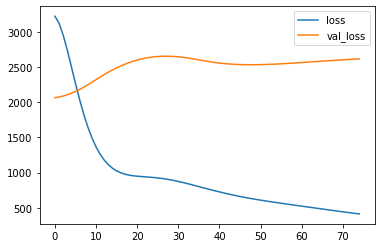

--------------------------------------- Current Engine : 97  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 144ms/step - loss: 10529.7715 - val_loss: 3681.9241
Epoch 2/75
1/1 [==============================] - 0s 166ms/step - loss: 10345.3506 - val_loss: 3652.5808
Epoch 3/75
1/1 [==============================] - 0s 74ms/step - loss: 9964.6045 - val_loss: 3610.6145
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 9420.9941 - val_loss: 3558.6062
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 8745.6611 - val_loss: 3498.9031
Epoch 6/75
1/1 [==============================] - 0s 53ms/step - loss: 7969.8042 - val_loss: 3433.5708
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 7123.4443 - val_loss: 3364.3760
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 6230.7866 - val_loss: 3292.8223
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 

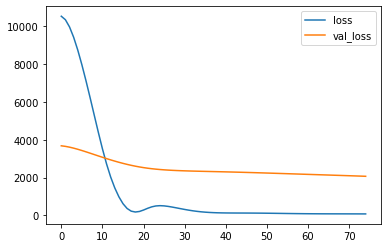

--------------------------------------- Current Engine : 98  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 126ms/step - loss: 355.2171 - val_loss: 3020.0315
Epoch 2/75
1/1 [==============================] - 0s 56ms/step - loss: 348.2650 - val_loss: 3009.2695
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 335.7264 - val_loss: 2995.3486
Epoch 4/75
1/1 [==============================] - 0s 61ms/step - loss: 319.1347 - val_loss: 2978.7690
Epoch 5/75
1/1 [==============================] - 0s 129ms/step - loss: 300.1964 - val_loss: 2960.0171
Epoch 6/75
1/1 [==============================] - 0s 54ms/step - loss: 280.6495 - val_loss: 2939.5576
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 262.1294 - val_loss: 2917.8105
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 246.0348 - val_loss: 2895.1462
Epoch 9/75
1/1 [==============================] - 0s 72ms/step - loss: 233.3981 -

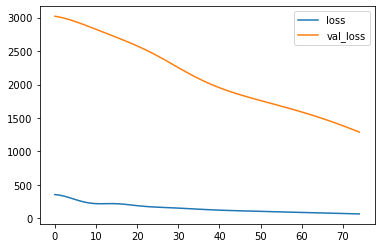

--------------------------------------- Current Engine : 99  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 213ms/step - loss: 294.6856 - val_loss: 1089.7271
Epoch 2/75
1/1 [==============================] - 0s 54ms/step - loss: 284.6063 - val_loss: 1074.5648
Epoch 3/75
1/1 [==============================] - 0s 98ms/step - loss: 266.1507 - val_loss: 1062.1715
Epoch 4/75
1/1 [==============================] - 0s 52ms/step - loss: 242.2112 - val_loss: 1051.9862
Epoch 5/75
1/1 [==============================] - 0s 68ms/step - loss: 215.7496 - val_loss: 1043.4253
Epoch 6/75
1/1 [==============================] - 0s 87ms/step - loss: 189.3362 - val_loss: 1035.9225
Epoch 7/75
1/1 [==============================] - 0s 101ms/step - loss: 164.9007 - val_loss: 1028.9568
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 143.6764 - val_loss: 1022.0718
Epoch 9/75
1/1 [==============================] - 0s 103ms/step - loss: 126.2649 

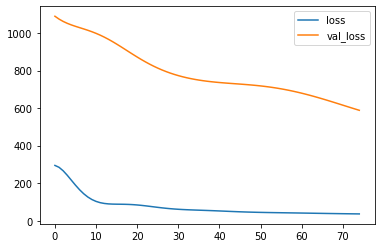

--------------------------------------- Current Engine : 100  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 150ms/step - loss: 1598.5940 - val_loss: 516.1628
Epoch 2/75
1/1 [==============================] - 0s 109ms/step - loss: 1517.6351 - val_loss: 536.0741
Epoch 3/75
1/1 [==============================] - 0s 71ms/step - loss: 1380.6578 - val_loss: 563.1358
Epoch 4/75
1/1 [==============================] - 0s 85ms/step - loss: 1210.0000 - val_loss: 595.7513
Epoch 5/75
1/1 [==============================] - 0s 108ms/step - loss: 1024.7014 - val_loss: 632.9755
Epoch 6/75
1/1 [==============================] - 0s 54ms/step - loss: 840.3270 - val_loss: 675.9627
Epoch 7/75
1/1 [==============================] - 0s 81ms/step - loss: 669.1859 - val_loss: 734.6778
Epoch 8/75
1/1 [==============================] - 0s 77ms/step - loss: 520.0753 - val_loss: 832.7924
Epoch 9/75
1/1 [==============================] - 0s 64ms/step - loss: 396.9049 - 

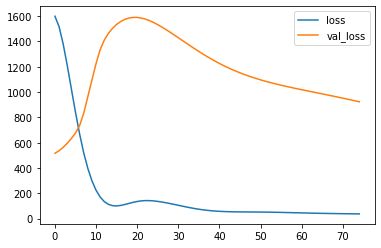

In [40]:
for i in range(len(X_train_new)):
    print("--------------------------------------- Current Engine :",i+1," ---------------------------------------")
    history = model.fit(
    X_train_new[i],
    y_train_new[i],
    batch_size=512,
    epochs=75,
    validation_split=0.15,
    verbose=1)
    # Loss Graph
    plt.plot(history.epoch, history.history['loss'] , label = "loss")
    plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")
    plt.legend()
    plt.show()

In [41]:
mses=[]
rmses=[]
maes=[]
for i in range(len(X_train_new)):
    
    print("--------------------------------------- Current Engine :",i+1," ---------------------------------------")
    
    y_train_pred = model.predict(X_train_new[i])
    
    mses.append(mean_squared_error(y_train_new[i],y_train_pred))
    rmses.append(math.sqrt(mean_squared_error(y_train_new[i],y_train_pred)))
    maes.append(mean_absolute_error(y_train_new[i],y_train_pred))
    
    print("mean_squared_error >> ", mean_squared_error(y_train_new[i],y_train_pred))
    print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train_new[i],y_train_pred)))
    print("mean_absolute_error >>",mean_absolute_error(y_train_new[i],y_train_pred))

--------------------------------------- Current Engine : 1  ---------------------------------------
mean_squared_error >>  1771.6346507395392
root_mean_squared_error >>  42.09079056919149
mean_absolute_error >> 39.11373277527193
--------------------------------------- Current Engine : 2  ---------------------------------------
mean_squared_error >>  1380.0718155549362
root_mean_squared_error >>  37.14931783431475
mean_absolute_error >> 27.475176714468695
--------------------------------------- Current Engine : 3  ---------------------------------------
mean_squared_error >>  1316.8044268712574
root_mean_squared_error >>  36.287799972873216
mean_absolute_error >> 34.62057197661627
--------------------------------------- Current Engine : 4  ---------------------------------------
mean_squared_error >>  780.9000710190759
root_mean_squared_error >>  27.94458929773483
mean_absolute_error >> 26.40963614388798
--------------------------------------- Current Engine : 5  -----------------------

mean_squared_error >>  7354.617560554612
root_mean_squared_error >>  85.75906692912774
mean_absolute_error >> 81.73636399275102
--------------------------------------- Current Engine : 38  ---------------------------------------
mean_squared_error >>  2522.9665312993416
root_mean_squared_error >>  50.22914026040404
mean_absolute_error >> 41.446195988055784
--------------------------------------- Current Engine : 39  ---------------------------------------
mean_squared_error >>  14442.766509695299
root_mean_squared_error >>  120.17806168221927
mean_absolute_error >> 116.72758702335194
--------------------------------------- Current Engine : 40  ---------------------------------------
mean_squared_error >>  1544.5356092774766
root_mean_squared_error >>  39.30058026642198
mean_absolute_error >> 32.743392383984926
--------------------------------------- Current Engine : 41  ---------------------------------------
mean_squared_error >>  291.1030297679102
root_mean_squared_error >>  17.06174

mean_squared_error >>  1739.9844048482407
root_mean_squared_error >>  41.71312029623582
mean_absolute_error >> 38.36467182046116
--------------------------------------- Current Engine : 74  ---------------------------------------
mean_squared_error >>  1328.7709543408744
root_mean_squared_error >>  36.452310685893075
mean_absolute_error >> 35.50736470376292
--------------------------------------- Current Engine : 75  ---------------------------------------
mean_squared_error >>  1520.6283486275915
root_mean_squared_error >>  38.99523494771626
mean_absolute_error >> 36.245758424111465
--------------------------------------- Current Engine : 76  ---------------------------------------
mean_squared_error >>  1246.9693491741878
root_mean_squared_error >>  35.31245317411675
mean_absolute_error >> 29.197289318295578
--------------------------------------- Current Engine : 77  ---------------------------------------
mean_squared_error >>  8129.6685838378135
root_mean_squared_error >>  90.1646

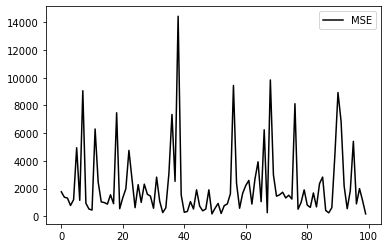

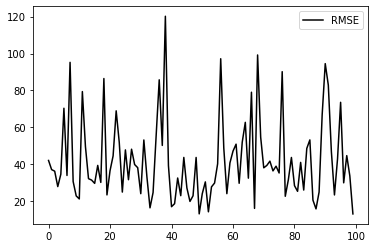

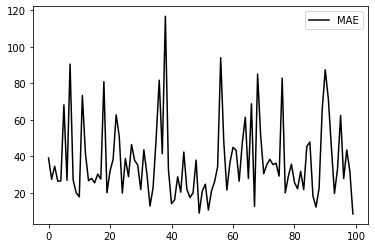

In [65]:
plt.plot(mses,c='k',label='MSE')
#plt.plot(rmses,c='red',label='RMSE')
plt.legend()
plt.show()

plt.plot(rmses,c='k',label='RMSE')
plt.legend()
plt.show()

plt.plot(maes,c='k',label='MAE')
#plt.plot(rmses,c='red',label='RMSE')
plt.legend()
plt.show()

In [42]:
mses = np.array(mses)
rmses = np.array(rmses)
maes = np.array(maes)

print("MSE :",np.mean(mses))
print("RMSES :",np.mean(rmses))
print("MAES :",np.mean(maes))

MSE : 2249.894126655503
RMSES : 42.08619001761008
MAES : 37.56749873650257


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [43]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [44]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [45]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
#max_cycles[0] = max_cycles[0] - 21

In [46]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [47]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [48]:
X_test = np.array(df_test)

y_test = np.array(df_rul)

print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [49]:
X_test_new = []
i = 0
count = 0
while i < len(X_test):
    temp_x = []
    j = int(max_cycles[count])
    count = count+1
    if j == 0:
        break
    while j!=0:
        temp_x.append(X_test[i])
        i=i+1
        j=j-1
    X_test_new.append(temp_x)

In [50]:
def create_dataset(X, look_back=10):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [51]:
for i in range(len(X_test_new)):
    X_test_new[i] = create_dataset(X_test_new[i])
#y_test = y_test[6:]

In [52]:
using_mean = []
using_last_index = []
predictions = []
for i in range(len(X_test_new)):
    print("-------------------------Current Engine :",i+1,"-----------------------------")
    pred = model.predict(X_test_new[i])
    using_mean.append(np.mean(pred))
    using_last_index.append(pred[-1])
    print("Actual RUL :",y_test[i])
    print("Predicted using last index :",pred[-1])
    print("Predicted using mean :",np.mean(pred))
    predictions.append(pred)

-------------------------Current Engine : 1 -----------------------------
Actual RUL : [112]
Predicted using last index : [189.34862]
Predicted using mean : 187.16823
-------------------------Current Engine : 2 -----------------------------
Actual RUL : [98]
Predicted using last index : [217.24586]
Predicted using mean : 215.83252
-------------------------Current Engine : 3 -----------------------------
Actual RUL : [69]
Predicted using last index : [46.411068]
Predicted using mean : 124.740524
-------------------------Current Engine : 4 -----------------------------
Actual RUL : [82]
Predicted using last index : [53.106495]
Predicted using mean : 149.18005
-------------------------Current Engine : 5 -----------------------------
Actual RUL : [91]
Predicted using last index : [52.466564]
Predicted using mean : 156.95103
-------------------------Current Engine : 6 -----------------------------
Actual RUL : [93]
Predicted using last index : [59.77618]
Predicted using mean : 150.486
-----

Actual RUL : [114]
Predicted using last index : [56.39735]
Predicted using mean : 142.83574
-------------------------Current Engine : 52 -----------------------------
Actual RUL : [29]
Predicted using last index : [44.491955]
Predicted using mean : 123.303764
-------------------------Current Engine : 53 -----------------------------
Actual RUL : [26]
Predicted using last index : [43.91778]
Predicted using mean : 102.64536
-------------------------Current Engine : 54 -----------------------------
Actual RUL : [97]
Predicted using last index : [108.885445]
Predicted using mean : 149.7075
-------------------------Current Engine : 55 -----------------------------
Actual RUL : [137]
Predicted using last index : [83.07944]
Predicted using mean : 134.18312
-------------------------Current Engine : 56 -----------------------------
Actual RUL : [15]
Predicted using last index : [44.126766]
Predicted using mean : 112.061676
-------------------------Current Engine : 57 ---------------------------

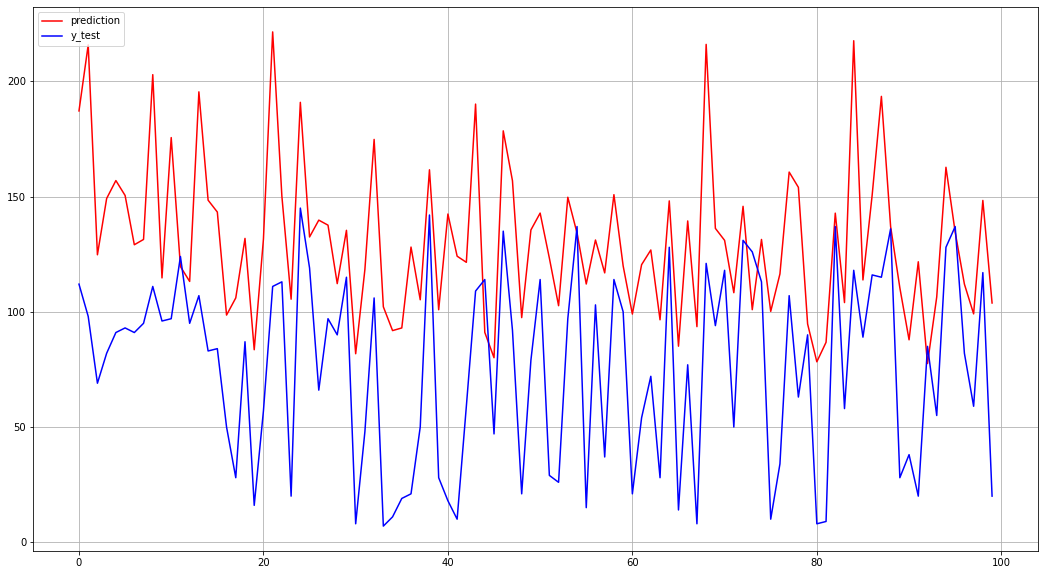

In [53]:
fig = plt.figure(figsize=(18,10))
plt.plot(using_mean,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [54]:
print("mean_squared_error >> ", mean_squared_error(y_test,using_mean))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,using_mean)))
print("mean_absolute_error >>",mean_absolute_error(y_test,using_mean))

mean_squared_error >>  4108.277438135757
root_mean_squared_error >>  64.09584571667462
mean_absolute_error >> 56.65666412353516


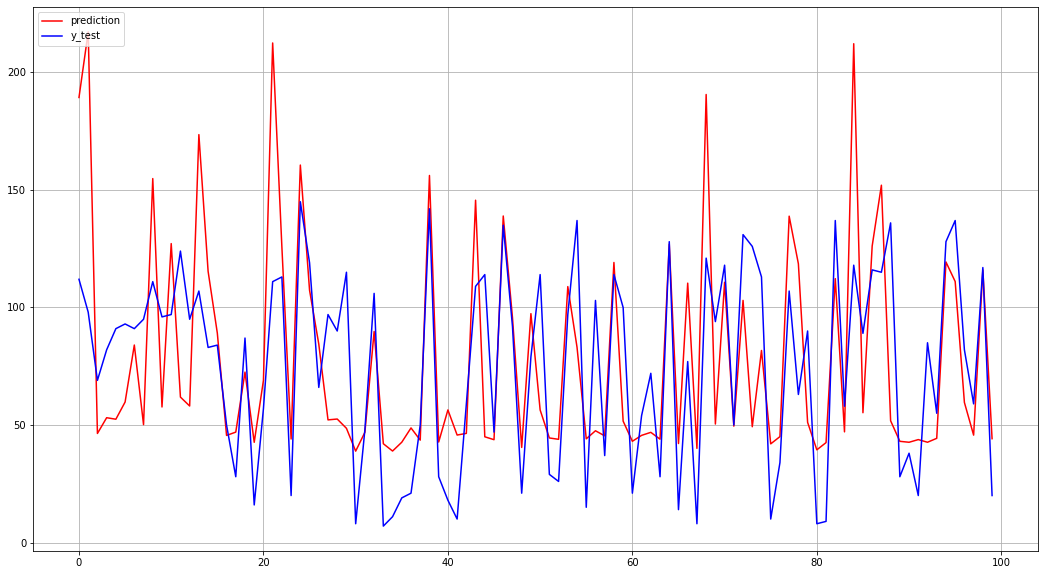

mean_squared_error >>  1420.6852168562555
root_mean_squared_error >>  37.6919781499493
mean_absolute_error >> 29.830351371765136


In [55]:
fig = plt.figure(figsize=(18,10))
plt.plot(using_last_index,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,using_last_index))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,using_last_index)))
print("mean_absolute_error >>",mean_absolute_error(y_test,using_last_index))

In [56]:
a = y_test

In [57]:
my_pred = using_last_index

In [58]:
actual = []
for i in range(len(a)):
    actual.append(a[i][0])

In [59]:
print(actual)

[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [60]:
print(my_pred)

[array([189.34862], dtype=float32), array([217.24586], dtype=float32), array([46.411068], dtype=float32), array([53.106495], dtype=float32), array([52.466564], dtype=float32), array([59.77618], dtype=float32), array([84.03065], dtype=float32), array([50.15994], dtype=float32), array([154.8475], dtype=float32), array([57.677372], dtype=float32), array([127.18587], dtype=float32), array([61.880722], dtype=float32), array([58.09953], dtype=float32), array([173.54402], dtype=float32), array([115.395584], dtype=float32), array([89.09005], dtype=float32), array([45.574863], dtype=float32), array([46.980015], dtype=float32), array([72.516075], dtype=float32), array([42.648014], dtype=float32), array([69.00343], dtype=float32), array([212.5389], dtype=float32), array([125.68657], dtype=float32), array([44.048096], dtype=float32), array([160.60034], dtype=float32), array([107.32229], dtype=float32), array([84.43855], dtype=float32), array([52.186085], dtype=float32), array([52.54838], dtype=flo

In [61]:
overestimation = []
percentage_errors = [[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(my_pred)):
    percentage_error = ((my_pred[i]-actual[i])/actual[i])*100
#     print(abs(int(percentage_error/10)))
    print("For engine",i,"overestimated RUL is :",percentage_error)
    if abs(int(percentage_error/10)) < 10:
        percentage_errors[abs(int(percentage_error/10))].append(percentage_error)
    else:
        percentage_errors[10].append(percentage_error)
    overestimation.append(my_pred[i]-actual[i])

For engine 0 overestimated RUL is : [69.061264]
For engine 1 overestimated RUL is : [121.67945]
For engine 2 overestimated RUL is : [-32.737583]
For engine 3 overestimated RUL is : [-35.235985]
For engine 4 overestimated RUL is : [-42.344437]
For engine 5 overestimated RUL is : [-35.724537]
For engine 6 overestimated RUL is : [-7.658629]
For engine 7 overestimated RUL is : [-47.200066]
For engine 8 overestimated RUL is : [39.502254]
For engine 9 overestimated RUL is : [-39.919403]
For engine 10 overestimated RUL is : [31.119452]
For engine 11 overestimated RUL is : [-50.09619]
For engine 12 overestimated RUL is : [-38.8426]
For engine 13 overestimated RUL is : [62.190674]
For engine 14 overestimated RUL is : [39.030823]
For engine 15 overestimated RUL is : [6.0595827]
For engine 16 overestimated RUL is : [-8.850273]
For engine 17 overestimated RUL is : [67.78577]
For engine 18 overestimated RUL is : [-16.64819]
For engine 19 overestimated RUL is : [166.5501]
For engine 20 overestimated

In [62]:
positive,negative,zeros = 0,0,0
for i in range(len(overestimation)):
    if overestimation[i] < 0:
        negative = negative + 1
    elif overestimation[i] > 0:
        positive = positive + 1
    else:
        zeros = zeros + 1

In [63]:
print("Overestimated RUL :",positive)
print("Underestimated RUL :",negative)
print("Correctly predicted RUL :",zeros)

Overestimated RUL : 54
Underestimated RUL : 46
Correctly predicted RUL : 0


In [64]:
for p in range(11):    
    if p < 10:
        print('Between',p*10,'and',(p+1)*10,'%','are :',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')
    else:
        print('Over',p*10,'% are',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')

Between 0 and 10 % are : 16 
 [array([-7.658629], dtype=float32), array([6.0595827], dtype=float32), array([-8.850273], dtype=float32), array([-9.813203], dtype=float32), array([-2.2664547], dtype=float32), array([9.976981], dtype=float32), array([-6.8983197], dtype=float32), array([2.909625], dtype=float32), array([4.0486126], dtype=float32), array([4.51877], dtype=float32), array([-0.82853436], dtype=float32), array([-6.161092], dtype=float32), array([-0.9639511], dtype=float32), array([8.735144], dtype=float32), array([-6.7465487], dtype=float32), array([-0.90678287], dtype=float32)] 


Between 10 and 20 % are : 12 
 [array([-16.64819], dtype=float32), array([11.227053], dtype=float32), array([10.758857], dtype=float32), array([-15.279676], dtype=float32), array([-12.843201], dtype=float32), array([12.253036], dtype=float32), array([-15.563435], dtype=float32), array([-18.04795], dtype=float32), array([-18.800196], dtype=float32), array([12.272915], dtype=float32), array([-19.381361